# Llama-Powered RE

## Contents:

- 1. Setup: Imports and Configuration
- 2. Exploratory Data Analysis (EDA)

### Relation Extraction (RE) with Llama

- 3. RE: Data Preparation
- 4. RE: Create Hugging Face Datasets
- 5. RE: Label Mapping and Llama Tokenizer
- 6. RE: Tokenization Function
- 7. RE: Data Collator and Metrics Function
- 8. RE: Llama Model Loading Utility & Handeling
- 9. RE Llama: Smoke Run - Basic Training Test
- 10. RE Llama: Full Fine-Tuning - Hyperparameter Search
- 11. RE Llama: LoRA Fine-Tuning - Hyperparameter Search
- 12. RE Llama: Partial Layer Freezing - Hyperparameter Search
- 13. RE Llama: Final Training Runs
- 14. RE Llama: Results Comparison and Visualization
- 15. RE Llama: Hyperparameter Analysis (Optuna Plots)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install --upgrade --force-reinstall numpy scipy scikit-learn
!pip install --upgrade torch torchvision transformers datasets peft optuna pandas matplotlib seaborn bitsandbytes accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 117.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.7/37.7 MB 67.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 127.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.7/307.7 kB 28.7 MB/s eta 0:00:00
  Attempting uninstall: threadpoolctl
    Found existing installation: threadpoolctl 3.6.0
    Uninstalling threadpoolctl-3.6.0:
      Successfully uninstalled threadpoolctl-3.6.0
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: joblib
    Found existing installation: joblib 1.5.0
    Uninstalling joblib-1.5.0:
      Successfully uninstalled joblib-1.5.0
  Attempting uninstall: scipy
    Found 

## 1. Setup: Imports and Configuration

In [ ]:
import os
import re
import random
import json
from pathlib import Path
from collections import Counter
import logging

import pandas as pd
import numpy as np
import torch
import sklearn
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix

from datasets import Dataset, DatasetDict, concatenate_datasets
from transformers import (
    AutoConfig,
    AutoTokenizer,
    AutoModelForTokenClassification,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorForTokenClassification,
    DataCollatorWithPadding,
    BitsAndBytesConfig # For potential 4-bit/8-bit quantization
)
from peft import get_peft_model, LoraConfig, TaskType, prepare_model_for_kbit_training
import optuna

# Configure logging
logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)
optuna_logger = logging.getLogger("optuna")
optuna_logger.setLevel(logging.WARNING)

#LLAMA_MODEL_NAME = "NousResearch/Llama-2-7b-hf"
LLAMA_MODEL_NAME = "openlm-research/open_llama_3b_v2"

USE_4BIT_QUANTIZATION = False # Quantization for testing

# Paths
BASE_DATA_PATH = Path("/content/drive/MyDrive/DocIE_dataset_final_version")
TRAIN_DIR = BASE_DATA_PATH / "train"
DEV_DIR   = BASE_DATA_PATH / "dev"
TEST_DIR  = BASE_DATA_PATH / "test"
OUTPUT_DIR = Path("./outputs")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print(f"Using Llama model: {LLAMA_MODEL_NAME}")
print(f"Using 4-bit quantization: {USE_4BIT_QUANTIZATION}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"Current CUDA device: {torch.cuda.get_device_name(torch.cuda.current_device())}")


Using Llama model: openlm-research/open_llama_3b_v2
Using 4-bit quantization: False
CUDA available: True
Current CUDA device: NVIDIA A100-SXM4-40GB


### 1.1 Data Loading Utility

In [ ]:
def load_docie_docs(folder: Path, recursive: bool = False):
    docs = []
    pattern = "**/*.json" if recursive else "*.json"
    file_paths = list(folder.glob(pattern))

    if not file_paths:
        print(f"Warning: No JSON files found in {folder} with pattern '{pattern}'.")
        return []

    for file_path in file_paths:
        try:
            data = json.loads(file_path.read_text(encoding="utf-8"))
            if isinstance(data, list):
                docs.extend(data)
            else:
                docs.append(data)
        except json.JSONDecodeError:
            print(f"Warning: Could not decode JSON from {file_path}. Skipping.")
        except Exception as e:
            print(f"Error loading {file_path}: {e}. Skipping.")
    return docs

# Load documents
train_docs_orig = load_docie_docs(TRAIN_DIR, recursive=True)
dev_docs_orig   = load_docie_docs(DEV_DIR, recursive=True)
test_docs_orig  = load_docie_docs(TEST_DIR, recursive=True)

print(f"Original Docs Loaded: Train: {len(train_docs_orig)} │ Dev: {len(dev_docs_orig)} │ Test: {len(test_docs_orig)}")

# Prepare documents for NER
def prepare_docs_for_ner(doc_list):
    prepared_docs = []
    for doc in doc_list:
        if not isinstance(doc, dict): continue
        doc_text = doc.get("document", doc.get("doc"))
        if doc_text:
            new_doc = {"id": doc.get("id", f"doc_{len(prepared_docs)}"), "document": str(doc_text)}
            new_doc["entities"] = doc.get("entities", [])
            new_doc["NER_label_set"] = doc.get("NER_label_set", [])
            prepared_docs.append(new_doc)
    return prepared_docs

train_docs_ner = prepare_docs_for_ner(train_docs_orig)
dev_docs_ner = prepare_docs_for_ner(dev_docs_orig)
test_docs_ner = prepare_docs_for_ner(test_docs_orig)

print(f"Docs for NER: Train: {len(train_docs_ner)} │ Dev: {len(dev_docs_ner)} │ Test: {len(test_docs_ner)}")

if train_docs_ner:
    print("Keys of the first processed NER train document:", train_docs_ner[0].keys())
else:
    print("No documents available for NER after preparation.")

Original Docs Loaded: Train: 51 │ Dev: 23 │ Test: 248
Docs for NER: Train: 51 │ Dev: 23 │ Test: 248
Keys of the first processed NER train document: dict_keys(['id', 'document', 'entities', 'NER_label_set'])


## 2. Exploratory Data Analysis (EDA)

NER Docs: Avg Tokens: 919.08, Max Tokens: 2560


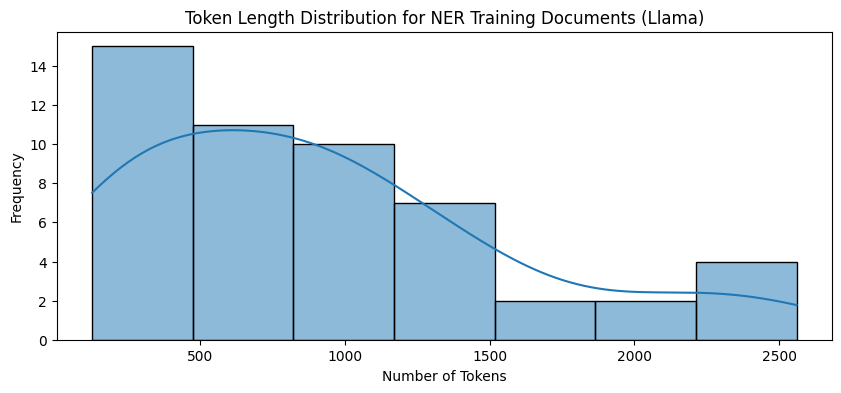


NER Entity Type Frequencies (Top 10): [('DATE', 647), ('MISC', 417), ('PERSON', 242), ('ORG', 241), ('CARDINAL', 224), ('GPE', 157), ('WORK_OF_ART', 65), ('NORP', 59), ('ORDINAL', 55), ('QUANTITY', 42)]


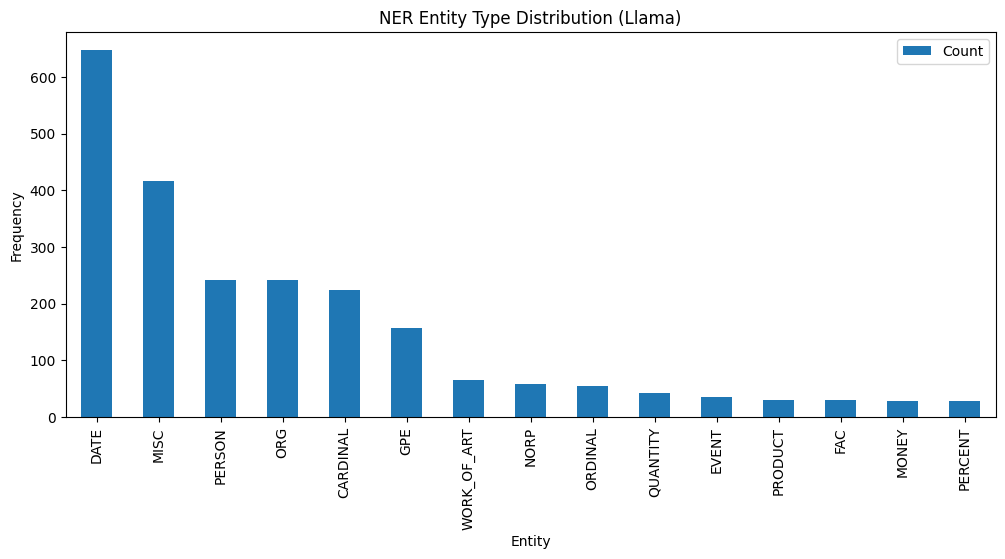


Relation Type Frequencies (Top 10 from original train docs): [('HasPart', 82), ('HasEffect', 67), ('DiplomaticRelation', 45), ('LocatedIn', 44), ('InterestedIn', 38), ('OwnerOf', 32), ('SaidToBeTheSameAs', 25), ('NominatedFor', 25), ('PartOf', 18), ('Creator', 17)]


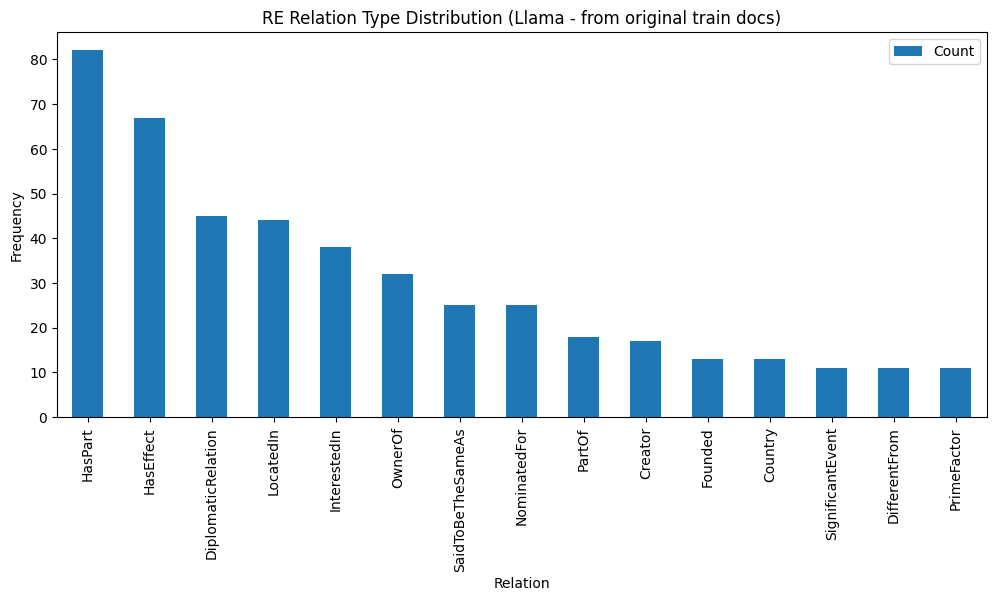

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
# ### 2.1 Document Length
if train_docs_ner:
    ner_lengths = [len(doc["document"].split()) for doc in train_docs_ner if doc.get("document")]
    if ner_lengths:
        print(f"NER Docs: Avg Tokens: {np.mean(ner_lengths):.2f}, Max Tokens: {np.max(ner_lengths)}")
        plt.figure(figsize=(10, 4))
        sns.histplot(ner_lengths, kde=True)
        plt.title("Token Length Distribution for NER Training Documents (Llama)")
        plt.xlabel("Number of Tokens")
        plt.ylabel("Frequency")
        plt.show()
    else:
        print("No valid document lengths to analyze for NER.")
else:
    print("No training documents available for NER EDA.")

# ### 2.2 Entity Type Distribution
if train_docs_ner:
    ner_entity_type_counts = Counter()
    for doc in train_docs_ner:
        if isinstance(doc.get("entities"), list):
            for entity in doc["entities"]:
                if isinstance(entity, dict) and "type" in entity:
                    ner_entity_type_counts[entity["type"]] += 1
    if ner_entity_type_counts:
        print("\nNER Entity Type Frequencies (Top 10):", ner_entity_type_counts.most_common(10))
        if len(ner_entity_type_counts) > 0:
            pd.DataFrame(ner_entity_type_counts.most_common(15), columns=['Entity', 'Count']).plot(kind='bar', x='Entity', figsize=(12,5))
            plt.title("NER Entity Type Distribution (Llama)")
            plt.ylabel("Frequency")
            plt.show()
    else:
        print("No entities found to analyze in NER training documents.")
else:
    print("No training documents available for NER EDA.")

# ### 2.3 Relation Type Distribution
if train_docs_orig:
    re_relation_type_counts = Counter()
    for doc in train_docs_orig:
        if isinstance(doc.get("triples"), list):
            for triple in doc["triples"]:
                if isinstance(triple, dict) and "relation" in triple:
                    re_relation_type_counts[triple["relation"]] += 1
    if re_relation_type_counts:
        print("\nRelation Type Frequencies (Top 10 from original train docs):", re_relation_type_counts.most_common(10))
        if len(re_relation_type_counts) > 0:
            pd.DataFrame(re_relation_type_counts.most_common(15), columns=['Relation', 'Count']).plot(kind='bar', x='Relation', figsize=(12,5))
            plt.title("RE Relation Type Distribution (Llama - from original train docs)")
            plt.ylabel("Frequency")
            plt.show()
    else:
        print("No relations found to analyze in original training documents for RE EDA.")
else:
    print("No original training documents available for RE EDA.")



## Relation Extraction (RE) with Llama

## 3. RE: Data Preparation

In [ ]:
re_examples = []
source_docs_for_re = {
    "train": train_docs_orig,
    "dev": dev_docs_orig,
    "test": test_docs_orig
}
for split, current_docs in source_docs_for_re.items():
    if not current_docs: continue
    for doc_idx, d in enumerate(current_docs):
        if not isinstance(d, dict): continue
        doc_text = d.get("document", d.get("doc"))
        doc_id = d.get("id", f"{split}_doc_{doc_idx}")
        triples = d.get("triples", [])
        entities_in_doc = d.get("entities", [])
        if not doc_text or not entities_in_doc: continue # Need entities for negative sampling

        entity_mention_map = {}
        for ent_obj in entities_in_doc:
            if isinstance(ent_obj, dict) and ent_obj.get("mentions") and isinstance(ent_obj["mentions"], list) and len(ent_obj["mentions"]) > 0:
                first_mention = ent_obj["mentions"][0]
                if isinstance(first_mention, str):
                     entity_mention_map[first_mention] = first_mention
                elif isinstance(first_mention, dict) and "span" in first_mention:
                     entity_mention_map[first_mention["span"]] = first_mention["span"]

        all_doc_entity_mentions = list(entity_mention_map.keys())

        true_pairs_relations = {}
        if triples: # Only process triples if they exist
            for t in triples:
                if isinstance(t, dict) and "head" in t and "tail" in t and "relation" in t:
                    true_pairs_relations[(t["head"], t["tail"])] = t["relation"]

            for (h, t), rel in true_pairs_relations.items():
                re_examples.append({"doc_id": doc_id, "split": split, "sentence": doc_text, "head": h, "tail": t, "label": rel})

        # Negative sampling only if we have positive examples and enough entities
        if triples and len(all_doc_entity_mentions) >= 2:
            num_positive = len(true_pairs_relations)
            num_negative_to_generate = num_positive * 1
            neg_count = 0
            attempts = 0
            max_attempts = num_negative_to_generate * 10

            while neg_count < num_negative_to_generate and attempts < max_attempts:
                attempts += 1
                try:
                    h_neg, t_neg = random.sample(all_doc_entity_mentions, 2)
                    if h_neg != t_neg and (h_neg, t_neg) not in true_pairs_relations:
                        re_examples.append({"doc_id": doc_id, "split": split, "sentence": doc_text, "head": h_neg, "tail": t_neg, "label": "no_relation"})
                        neg_count += 1
                except ValueError: break
print(f"Generated {len(re_examples)} RE examples in total.")


Generated 1658 RE examples in total.


## 4. RE: Create Hugging Face Datasets

In [ ]:
if re_examples:
    re_df = pd.DataFrame(re_examples)
    hf_train_re = Dataset.from_pandas(re_df[re_df["split"] == "train"])
    hf_dev_re = Dataset.from_pandas(re_df[re_df["split"] == "dev"])
    hf_test_re = Dataset.from_pandas(re_df[re_df["split"] == "test"])
else:
    print("No RE examples were generated. Creating empty datasets for RE.")
    schema = {"doc_id": [], "split": [], "sentence": [], "head": [], "tail": [], "label": []}
    hf_train_re = Dataset.from_dict(schema)
    hf_dev_re = Dataset.from_dict(schema)
    hf_test_re = Dataset.from_dict(schema)

re_dataset_dict = DatasetDict({"train": hf_train_re, "dev": hf_dev_re, "test": hf_test_re})
print("\nRE DatasetDict:")
print(re_dataset_dict)


RE DatasetDict:
DatasetDict({
    train: Dataset({
        features: ['doc_id', 'split', 'sentence', 'head', 'tail', 'label', '__index_level_0__'],
        num_rows: 1098
    })
    dev: Dataset({
        features: ['doc_id', 'split', 'sentence', 'head', 'tail', 'label', '__index_level_0__'],
        num_rows: 560
    })
    test: Dataset({
        features: ['doc_id', 'split', 'sentence', 'head', 'tail', 'label', '__index_level_0__'],
        num_rows: 0
    })
})


## 5. RE: Label Mapping and Llama Tokenizer


In [ ]:
if re_dataset_dict["train"].num_rows > 0 or re_dataset_dict["dev"].num_rows > 0:
    all_re_labels_list = sorted(list(set(re_dataset_dict["train"]["label"]) | set(re_dataset_dict["dev"]["label"])))
else:
    all_re_labels_list = ["no_relation", "works_at", "located_in"] # Fallback
if "no_relation" not in all_re_labels_list:
    all_re_labels_list.append("no_relation")
all_re_labels_list = sorted(list(set(all_re_labels_list)))

re_label2id = {label: i for i, label in enumerate(all_re_labels_list)}
re_id2label = {i: label for i, label in enumerate(all_re_labels_list)}
print(f"Number of RE Labels: {len(all_re_labels_list)}")

re_tokenizer = AutoTokenizer.from_pretrained(LLAMA_MODEL_NAME, use_fast=True)
if re_tokenizer.pad_token is None:
    re_tokenizer.pad_token = re_tokenizer.eos_token
print(f"RE Tokenizer PAD token: '{re_tokenizer.pad_token}' (ID: {re_tokenizer.pad_token_id})")


Number of RE Labels: 74


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama.LlamaTokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565 - if you lo

RE Tokenizer PAD token: '</s>' (ID: 2)


## 6. RE: Tokenization Function

In [ ]:
RE_MAX_LENGTH = 256

def tokenize_re_llama_map(examples):
    # Ensure 'head', 'tail', 'sentence', 'label' are lists for batched processing
    heads = examples['head'] if isinstance(examples['head'], list) else [examples['head']]
    tails = examples['tail'] if isinstance(examples['tail'], list) else [examples['tail']]
    sentences = examples['sentence'] if isinstance(examples['sentence'], list) else [examples['sentence']]
    labels_text = examples['label'] if isinstance(examples['label'], list) else [examples['label']]

    inputs_a = [str(h) for h in heads]
    inputs_b = [f"{str(t)} {re_tokenizer.sep_token if re_tokenizer.sep_token else ' '} {str(s)}" for t, s in zip(tails, sentences)]

    tokenized = re_tokenizer(
        inputs_a,
        inputs_b,
        truncation="only_second",
        max_length=RE_MAX_LENGTH,
        padding="max_length"
    )
    tokenized["label"] = [re_label2id[lt] for lt in labels_text]
    return tokenized

if re_dataset_dict["train"].num_rows > 0:
    re_tokenized_dataset = re_dataset_dict.map(
        tokenize_re_llama_map,
        batched=True,
        remove_columns=["doc_id", "split", "sentence", "head", "tail"]
    )
    print("RE datasets tokenized.")
else:
    re_tokenized_dataset = DatasetDict({
        "train": Dataset.from_dict({"input_ids": [], "attention_mask": [], "label": []}),
        "dev": Dataset.from_dict({"input_ids": [], "attention_mask": [], "label": []}),
        "test": Dataset.from_dict({"input_ids": [], "attention_mask": [], "label": []})
    })
    print("Skipping RE dataset tokenization (train is empty).")
print(re_tokenized_dataset)

Map:   0%|          | 0/1098 [00:00<?, ? examples/s]

Map:   0%|          | 0/560 [00:00<?, ? examples/s]

RE datasets tokenized.
DatasetDict({
    train: Dataset({
        features: ['label', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 1098
    })
    dev: Dataset({
        features: ['label', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 560
    })
    test: Dataset({
        features: ['label', '__index_level_0__'],
        num_rows: 0
    })
})


## 7. RE: Data Collator and Metrics Function

In [ ]:
re_data_collator = DataCollatorWithPadding(tokenizer=re_tokenizer, padding="max_length", max_length=RE_MAX_LENGTH)
print("Data collator for RE initialized.")

def compute_metrics_re_llama(p_eval): # Same as NER for sequence classification
    predictions, actual_labels = p_eval
    predictions = np.argmax(predictions, axis=1)
    if not len(actual_labels): return {"f1_micro": 0.0, "f1_macro": 0.0, "accuracy": 0.0}
    precision_micro, recall_micro, f1_micro, _ = precision_recall_fscore_support(actual_labels, predictions, average='micro', zero_division=0)
    precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(actual_labels, predictions, average='macro', zero_division=0)
    accuracy = accuracy_score(actual_labels, predictions)
    return {"precision_micro": precision_micro, "recall_micro": recall_micro, "f1_micro": f1_micro,
            "precision_macro": precision_macro, "recall_macro": recall_macro, "f1_macro": f1_macro, "accuracy": accuracy}
print("Metrics function for Llama RE defined.")

Data collator for RE initialized.
Metrics function for Llama RE defined.


## 8. RE: Llama Model Loading Utility & Handeling

In [ ]:
def get_llama_re_model(quantization_config=None): # Renamed for clarity
    model = AutoModelForSequenceClassification.from_pretrained(
        LLAMA_MODEL_NAME,
        num_labels=len(re_label2id), id2label=re_id2label, label2id=re_label2id,
        quantization_config=quantization_config, trust_remote_code=True, ignore_mismatched_sizes=True
    )
    model.config.pad_token_id = re_tokenizer.pad_token_id
    if len(re_tokenizer) > model.get_input_embeddings().weight.size(0):
        model.resize_token_embeddings(len(re_tokenizer))
    return model
print("RE Llama model loading utility defined.")

RE Llama model loading utility defined.


In [ ]:
def get_llama_re_model(quantization_config=None, dtype_override=None, device_override=None):
    print(f"🔄 Loading Llama RE model: {LLAMA_MODEL_NAME}")
    print(f"   dtype_override: {dtype_override}, quantization_config: {'Present' if quantization_config else 'None'}")

    global re_label2id, re_id2label, re_tokenizer

    model_args = {
        "num_labels": len(re_label2id),
        "id2label": re_id2label,
        "label2id": re_label2id,
        "quantization_config": quantization_config,
        "trust_remote_code": True,
        "ignore_mismatched_sizes": True,
        "low_cpu_mem_usage": True
    }

    # Determine torch_dtype
    if dtype_override:
        model_args["torch_dtype"] = dtype_override
    elif quantization_config is None: # Not quantized
        if torch.cuda.is_available():
            if torch.cuda.is_bf16_supported():
                model_args["torch_dtype"] = torch.bfloat16
                print("   Using bfloat16 on GPU for non-quantized RE model (default)")
            else:
                model_args["torch_dtype"] = torch.float16
                print("   Using float16 on GPU for non-quantized RE model (bf16 not supported, default)")
        else: # CPU
             model_args["torch_dtype"] = torch.float32
             print("   Using float32 on CPU for non-quantized RE model (default)")
    elif quantization_config and hasattr(quantization_config, 'bnb_4bit_compute_dtype'): # Check attribute exists
         print(f"   Quantization config present for RE. Compute dtype: {quantization_config.bnb_4bit_compute_dtype}")

    if device_override:
        model_args["device_map"] = device_override
    elif quantization_config is not None:
         model_args["device_map"] = "auto"

    effective_dtype = model_args.get("torch_dtype", "Handled by quantization or default")
    print(f"   Attempting to load RE model with effective torch_dtype: {effective_dtype}")

    model = AutoModelForSequenceClassification.from_pretrained(
        LLAMA_MODEL_NAME,
        **model_args
    )
    print(f"✅ RE Model loaded. Initial model dtype: {model.dtype}")

    # Re-initialize classification head IF NOT using quantization
    if quantization_config is None: # Apply for non-quantized fp16/bf16/fp32
        print("   Re-initializing RE classification head (model.score) for numerical stability...")
        if hasattr(model, 'score') and model.score is not None:
            model.score.weight.data.normal_(mean=0.0, std=0.02)
            if model.score.bias is not None:
                model.score.bias.data.zero_()
            print("   RE Classification head re-initialized.")
        else:
            print("   WARNING: Could not find 'score' layer to re-initialize for RE model.")


    if hasattr(re_tokenizer, 'pad_token_id') and re_tokenizer.pad_token_id is not None:
        model.config.pad_token_id = re_tokenizer.pad_token_id
        print(f"   Model pad_token_id set to: {model.config.pad_token_id}")

    current_vocab_size_re = model.get_input_embeddings().weight.size(0)
    tokenizer_vocab_size_re = len(re_tokenizer)
    if tokenizer_vocab_size_re > current_vocab_size_re:
        model.resize_token_embeddings(len(re_tokenizer))
        print(f"   Resized RE token embeddings to {len(re_tokenizer)}")

    return model

## Smoke Run , Need to decide !!

In [ ]:
# Cell 37: Fixed RE Llama Smoke Run - MODIFIED FOR QUANTIZATION
import gc
import torch
from transformers import TrainingArguments, Trainer, BitsAndBytesConfig # Ensure BitsAndBytesConfig
from peft import LoraConfig, get_peft_model, TaskType, prepare_model_for_kbit_training # Ensure all PEFT imports

# Define clear_gpu_memory at the top of the cell
def clear_gpu_memory():
    """Clear GPU memory cache"""
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        gc.collect()

# Initialize default metrics
smoke_metrics_re_llama = {"eval_f1_micro": 0.0, "eval_f1_macro": 0.0, "eval_accuracy": 0.0}
# baseline_re_llama_results = smoke_metrics_re_llama # This will be updated by the successful run

# --- Define bnb_config_for_re_smoke based on USE_4BIT_QUANTIZATION ---
if 'USE_4BIT_QUANTIZATION' not in globals():
    print("WARNING: Global USE_4BIT_QUANTIZATION not defined for RE smoke run. Defaulting to True to attempt quantization.")
    USE_4BIT_QUANTIZATION_RE_SMOKE = True # Default to trying quantization for RE
else:
    USE_4BIT_QUANTIZATION_RE_SMOKE = USE_4BIT_QUANTIZATION

bnb_config_for_re_smoke = None
if USE_4BIT_QUANTIZATION_RE_SMOKE and BitsAndBytesConfig is not None and torch.cuda.is_available():
    try:
        bnb_config_for_re_smoke = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_use_double_quant=True,
            bnb_4bit_quant_type="nf4",
            bnb_4bit_compute_dtype=torch.bfloat16 if torch.cuda.is_bf16_supported() else torch.float16
        )
        print("✅ 4-bit quantization config created for RE smoke run.")
    except Exception as e:
        print(f"⚠️ Error configuring BitsAndBytesConfig for RE smoke run, will proceed without quantization: {e}")
        USE_4BIT_QUANTIZATION_RE_SMOKE = False # Fallback
        bnb_config_for_re_smoke = None
elif USE_4BIT_QUANTIZATION_RE_SMOKE:
    print("⚠️ Quantization requested for RE smoke run but BitsAndBytesConfig or CUDA not available. Proceeding without quantization.")
    USE_4BIT_QUANTIZATION_RE_SMOKE = False
else:
    print("ℹ️ Proceeding without quantization for RE smoke run (USE_4BIT_QUANTIZATION_RE_SMOKE is False).")
# --- End of bnb_config_for_re_smoke definition ---


if 're_tokenized_dataset' not in globals() or \
   'get_llama_re_model' not in globals() or \
   're_data_collator' not in globals() or \
   're_tokenizer' not in globals() or \
   'compute_metrics_re_llama' not in globals() or \
   'OUTPUT_DIR' not in globals():
    print("❌ CRITICAL ERROR: One or more prerequisite variables/functions are missing for RE smoke run.")
    # smoke_metrics_re_llama will retain defaults
elif re_tokenized_dataset["train"].num_rows > 0 and re_tokenized_dataset["dev"].num_rows > 0:
    print("🚀 Attempting Llama RE smoke run...")
    clear_gpu_memory() # Now this call is valid

    approach = "" # Will be set below

    try:
        # ... (rest of your Cell 37 code from the `if USE_4BIT_QUANTIZATION_RE_SMOKE ...` line)
        if USE_4BIT_QUANTIZATION_RE_SMOKE and bnb_config_for_re_smoke:
            approach = "quantized_with_lora"
            print("🔧 Quantized model detected - using LoRA adapters for RE")
        else:
            approach = "traditional"
            print("🔧 Non-quantized model - using traditional fine-tuning for RE (High memory risk!)")

        print("🔄 Loading RE model...")
        # Pass the locally defined bnb_config_for_re_smoke
        re_llama_smoke_model = get_llama_re_model(quantization_config=bnb_config_for_re_smoke)

        fp16_enabled_re_smoke = False
        bf16_enabled_re_smoke = False
        optimizer_re_smoke = "adamw_torch"

        if USE_4BIT_QUANTIZATION_RE_SMOKE and bnb_config_for_re_smoke: # If quantization is active
            re_llama_smoke_model = prepare_model_for_kbit_training(re_llama_smoke_model)
            print("🔗 Adding LoRA adapters for RE...")
            lora_config = LoraConfig(
                task_type=TaskType.SEQ_CLS,
                r=4,
                lora_alpha=8,
                lora_dropout=0.1,
                target_modules=["q_proj", "v_proj"],
                bias="none"
            )
            re_llama_smoke_model = get_peft_model(re_llama_smoke_model, lora_config)
            re_llama_smoke_model.print_trainable_parameters()
            print("✅ LoRA adapters attached to RE model")

            if bnb_config_for_re_smoke.bnb_4bit_compute_dtype == torch.bfloat16:
                bf16_enabled_re_smoke = True
            else:
                fp16_enabled_re_smoke = True
            optimizer_re_smoke = "paged_adamw_8bit"
        else:
            trainable_params = sum(p.numel() for p in re_llama_smoke_model.parameters() if p.requires_grad)
            print(f"📊 Traditional RE: {trainable_params/1e6:.1f}M trainable parameters")
            if torch.cuda.is_available():
                if torch.cuda.is_bf16_supported():
                    bf16_enabled_re_smoke = True
                else:
                    fp16_enabled_re_smoke = True

        print(f"🎯 Training settings for RE smoke: fp16={fp16_enabled_re_smoke}, bf16={bf16_enabled_re_smoke}, optim={optimizer_re_smoke}")

        re_smoke_args = TrainingArguments(
            output_dir=OUTPUT_DIR / "llama_re_smoke_run",
            per_device_train_batch_size=1,
            per_device_eval_batch_size=1,
            gradient_accumulation_steps=32,
            eval_strategy="steps",
            eval_steps=5,
            logging_steps=2,
            max_steps=10,
            learning_rate=5e-5 if (USE_4BIT_QUANTIZATION_RE_SMOKE and bnb_config_for_re_smoke) else 1e-5,
            fp16=fp16_enabled_re_smoke,
            bf16=bf16_enabled_re_smoke,
            report_to="none",
            save_strategy="no",
            optim=optimizer_re_smoke,
            gradient_checkpointing=True,
            dataloader_pin_memory=False,
            remove_unused_columns=True,
        )

        print("🏃 Creating RE trainer...")
        re_smoke_trainer = Trainer(
            model=re_llama_smoke_model,
            args=re_smoke_args,
            train_dataset=re_tokenized_dataset["train"],
            eval_dataset=re_tokenized_dataset["dev"],
            data_collator=re_data_collator,
            tokenizer=re_tokenizer,
            compute_metrics=compute_metrics_re_llama
        )

        print("🚀 Starting RE smoke training...")
        re_smoke_trainer.train()

        print("📊 Running RE evaluation...")
        current_smoke_metrics_re = re_smoke_trainer.evaluate()
        smoke_metrics_re_llama.update(current_smoke_metrics_re)

        print("✅ Llama RE Smoke Run SUCCESSFUL!")
        print("📈 RE Smoke-Run Metrics:", smoke_metrics_re_llama)

        del re_smoke_trainer
        del re_llama_smoke_model
        if 'base_model_re_lora_opt' in locals():
            del base_model_re_lora_opt
        clear_gpu_memory()
        print("🧹 Memory cleaned up")

    except torch.cuda.OutOfMemoryError as e:
        print(f"❌ CUDA OOM during RE smoke run: {str(e)[:200]}...")
        print("💡 Suggestions: If using LoRA, ensure r is small (e.g., 4). Increase gradient_accumulation_steps further. Otherwise, this model/task may require more VRAM or CPU offloading for RE.")
        clear_gpu_memory()
    except Exception as e:
        print(f"❌ Llama RE smoke run failed: {e}")
        import traceback
        traceback.print_exc()
        clear_gpu_memory()

else:
    print("⚠️  Skipping Llama RE smoke run: Training or development dataset is empty.")
    # This part was missing the 'locals()' check, added for safety
    train_rows = re_tokenized_dataset['train'].num_rows if 're_tokenized_dataset' in locals() and 'train' in re_tokenized_dataset else 'N/A'
    dev_rows = re_tokenized_dataset['dev'].num_rows if 're_tokenized_dataset' in locals() and 'dev' in re_tokenized_dataset else 'N/A'
    print(f"   Train size: {train_rows}")
    print(f"   Dev size: {dev_rows}")

print(f"\n📋 RE SMOKE RUN SUMMARY:")
print(f"   Status: {'✅ SUCCESS' if smoke_metrics_re_llama.get('eval_f1_micro', 0) > 0 else '❌ FAILED'}")
approach_summary = approach if 'approach' in locals() and approach else 'N/A (skipped or pre-approach error)'
print(f"   Approach: {approach_summary}")
print(f"   F1 Micro: {smoke_metrics_re_llama.get('eval_f1_micro', 0.0):.4f}")
print(f"   F1 Macro: {smoke_metrics_re_llama.get('eval_f1_macro', 0.0):.4f}")
print(f"   Accuracy: {smoke_metrics_re_llama.get('eval_accuracy', 0.0):.4f}")

clear_gpu_memory()
print("✅ RE smoke run cell finished.")

ℹ️ Proceeding without quantization for RE smoke run (USE_4BIT_QUANTIZATION_RE_SMOKE is False).
🚀 Attempting Llama RE smoke run...
🔧 Non-quantized model - using traditional fine-tuning for RE (High memory risk!)
🔄 Loading RE model...
🔄 Loading Llama RE model: openlm-research/open_llama_3b_v2
   dtype_override: None, quantization_config: None
   Using bfloat16 on GPU for non-quantized RE model (default)
   Attempting to load RE model with effective torch_dtype: torch.bfloat16


Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at openlm-research/open_llama_3b_v2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-12-a5674724a26a>:130: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  re_smoke_trainer = Trainer(


✅ RE Model loaded. Initial model dtype: torch.bfloat16
   Re-initializing RE classification head (model.score) for numerical stability...
   RE Classification head re-initialized.
   Model pad_token_id set to: 2
📊 Traditional RE: 3324.3M trainable parameters
🎯 Training settings for RE smoke: fp16=False, bf16=True, optim=adamw_torch
🏃 Creating RE trainer...


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.


🚀 Starting RE smoke training...


Step,Training Loss,Validation Loss,Precision Micro,Recall Micro,F1 Micro,Precision Macro,Recall Macro,F1 Macro,Accuracy
5,4.268400,4.812598,0.057143,0.057143,0.057143,0.025822,0.010816,0.014795,0.057143
10,3.995000,4.714293,0.082143,0.082143,0.082143,0.026295,0.011830,0.016161,0.082143


📊 Running RE evaluation...


✅ Llama RE Smoke Run SUCCESSFUL!
📈 RE Smoke-Run Metrics: {'eval_f1_micro': 0.08214285714285714, 'eval_f1_macro': 0.016161086342046216, 'eval_accuracy': 0.08214285714285714, 'eval_loss': 4.714292526245117, 'eval_precision_micro': 0.08214285714285714, 'eval_recall_micro': 0.08214285714285714, 'eval_precision_macro': 0.026295255930087393, 'eval_recall_macro': 0.011829573934837091, 'eval_runtime': 19.7694, 'eval_samples_per_second': 28.327, 'eval_steps_per_second': 28.327, 'epoch': 0.29143897996357016}
🧹 Memory cleaned up

📋 RE SMOKE RUN SUMMARY:
   Status: ✅ SUCCESS
   Approach: traditional
   F1 Micro: 0.0821
   F1 Macro: 0.0162
   Accuracy: 0.0821
✅ RE smoke run cell finished.



## 10. RE Llama: Full Fine-Tuning - Hyperparameter Search

In [ ]:
import gc
import torch
from peft import LoraConfig, get_peft_model, TaskType

def clear_gpu_memory():
    """Clear GPU memory cache"""
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        gc.collect()

# Initialize defaults
BEST_PARAMS_RE_LLAMA_FT = {"learning_rate": 2e-5, "batch_size_train": 1, "gradient_accumulation_steps": 8}
final_re_ft_metrics_llama = {"eval_f1_micro": 0.0, "eval_f1_macro": 0.0, "eval_accuracy": 0.0}

if re_tokenized_dataset["train"].num_rows > 0 and re_tokenized_dataset["dev"].num_rows > 0:
    print("🔍 Analyzing RE Full Fine-Tuning approach...")

    # Determine approach based on quantization
    if USE_4BIT_QUANTIZATION:
        approach = "quantized_full_ft_with_lora"
        print("🔧 Quantized model detected - using LoRA for 'full' fine-tuning")
    else:
        approach = "traditional_full_ft"
        print("🔧 Non-quantized model - using traditional full fine-tuning")

    def re_llama_ft_objective_optuna(trial):
        clear_gpu_memory()

        lr = trial.suggest_float("learning_rate", 1e-5, 5e-5, log=True)
        batch_size_train = trial.suggest_categorical("batch_size_train", [1, 2])  # Allow larger batches
        gradient_accumulation_steps = trial.suggest_categorical("gradient_accumulation_steps", [8, 16])

        try:
            print(f"🔄 Loading RE model for trial {trial.number} (approach: {approach})...")
            model_re_ft_opt = get_llama_re_model(quantization_config=bnb_config if USE_4BIT_QUANTIZATION else None)

            if USE_4BIT_QUANTIZATION:
                model_re_ft_opt = prepare_model_for_kbit_training(model_re_ft_opt)

                # Add comprehensive LoRA adapters for "full" fine-tuning
                lora_config = LoraConfig(
                    task_type=TaskType.SEQ_CLS,  # Sequence classification for RE
                    r=32,
                    lora_alpha=64,
                    lora_dropout=0.1,
                    target_modules=[
                        "q_proj", "v_proj", "k_proj", "o_proj",
                        "gate_proj", "up_proj", "down_proj"
                    ],
                    bias="none"
                )
                model_re_ft_opt = get_peft_model(model_re_ft_opt, lora_config)

                trainable_params = sum(p.numel() for p in model_re_ft_opt.parameters() if p.requires_grad)
                total_params = sum(p.numel() for p in model_re_ft_opt.parameters())
                print(f"📊 LoRA RE Full FT: {trainable_params/1e6:.2f}M trainable ({100 * trainable_params / total_params:.2f}%)")

                # Quantized settings
                fp16_enabled = False
                bf16_enabled = (bnb_config.bnb_4bit_compute_dtype == torch.bfloat16)
                optimizer = "paged_adamw_8bit"

            else:
                # Traditional full fine-tuning
                trainable_params = sum(p.numel() for p in model_re_ft_opt.parameters() if p.requires_grad)
                print(f"📊 Traditional RE Full FT: {trainable_params/1e6:.2f}M trainable parameters")

                # Non-quantized settings
                use_bf16 = torch.cuda.is_available() and torch.cuda.is_bf16_supported()
                use_fp16 = torch.cuda.is_available() and not use_bf16
                fp16_enabled = use_fp16
                bf16_enabled = use_bf16
                optimizer = "adamw_torch"

            args_re_ft_opt = TrainingArguments(
                output_dir=OUTPUT_DIR / f"llama_re_ft_optuna/trial_{trial.number}",
                per_device_train_batch_size=batch_size_train,
                per_device_eval_batch_size=batch_size_train,
                gradient_accumulation_steps=gradient_accumulation_steps,
                eval_strategy="steps",
                eval_steps=25,
                logging_steps=10,
                max_steps=100,
                learning_rate=lr,
                fp16=fp16_enabled,
                bf16=bf16_enabled,
                report_to="none",
                save_strategy="no",
                optim=optimizer,
                # Memory optimization
                gradient_checkpointing=True,
                dataloader_pin_memory=False,
                remove_unused_columns=True,
            )

            trainer_re_ft_opt = Trainer(
                model=model_re_ft_opt,
                args=args_re_ft_opt,
                train_dataset=re_tokenized_dataset["train"],
                eval_dataset=re_tokenized_dataset["dev"],
                data_collator=re_data_collator,
                tokenizer=re_tokenizer,
                compute_metrics=compute_metrics_re_llama
            )

            print(f"🚀 Starting RE training for trial {trial.number}...")
            trainer_re_ft_opt.train()
            metrics = trainer_re_ft_opt.evaluate()

            print(f"✅ Trial {trial.number} completed: F1_macro = {metrics.get('eval_f1_macro', 0.0):.4f}")

            # Cleanup
            del trainer_re_ft_opt
            del model_re_ft_opt
            clear_gpu_memory()

            return metrics.get("eval_f1_macro", 0.0)

        except torch.cuda.OutOfMemoryError as e:
            print(f"❌ Trial {trial.number}: CUDA OOM - {str(e)[:100]}...")
            clear_gpu_memory()
            return 0.0

        except Exception as e:
            print(f"❌ Trial {trial.number}: Failed - {e}")
            clear_gpu_memory()
            return 0.0

    print("🚀 Starting Optuna for Llama RE Full Fine-Tuning...")
    clear_gpu_memory()

    study_re_llama_ft = optuna.create_study(direction="maximize")
    try:
        study_re_llama_ft.optimize(re_llama_ft_objective_optuna, n_trials=1)

        if study_re_llama_ft.best_value > 0:
            BEST_PARAMS_RE_LLAMA_FT = study_re_llama_ft.best_params
            final_re_ft_metrics_llama = {"eval_f1_macro": study_re_llama_ft.best_value}
            print("🏆 Best Llama RE Full FT params:", BEST_PARAMS_RE_LLAMA_FT, "→ F1_macro =", study_re_llama_ft.best_value)
        else:
            print("❌ RE Full fine-tuning failed despite feasibility analysis")

    except Exception as e:
        print(f"❌ Optuna study for Llama RE Full FT failed: {e}")
        print(f"Error type: {type(e).__name__}")

        if "quantized" in str(e).lower():
            print("💡 Quantization issue - using LoRA adapters for quantized models")
        else:
            print("💡 Check error details above")

    finally:
        clear_gpu_memory()

else:
    print("⚠️  Skipping Optuna for Llama RE Full FT: Training or dev dataset empty.")
    print(f"   Train size: {re_tokenized_dataset['train'].num_rows if 're_tokenized_dataset' in locals() else 'N/A'}")
    print(f"   Dev size: {re_tokenized_dataset['dev'].num_rows if 're_tokenized_dataset' in locals() else 'N/A'}")
    study_re_llama_ft = None

print(f"\n📊 RE FULL FINE-TUNING SUMMARY:")
print(f"   Approach: {approach if 'approach' in locals() else 'N/A'}")
print(f"   Status: {'✅ SUCCESS' if final_re_ft_metrics_llama.get('eval_f1_macro', 0) > 0 else '❌ FAILED'}")
print(f"   Best F1 Macro: {final_re_ft_metrics_llama.get('eval_f1_macro', 0):.4f}")
print(f"   Parameters: {BEST_PARAMS_RE_LLAMA_FT}")

# Final cleanup
clear_gpu_memory()
print("✅ RE Full FT optimization completed")

🔍 Analyzing RE Full Fine-Tuning approach...
🔧 Non-quantized model - using traditional full fine-tuning
🚀 Starting Optuna for Llama RE Full Fine-Tuning...
🔄 Loading RE model for trial 0 (approach: traditional_full_ft)...
🔄 Loading Llama RE model: openlm-research/open_llama_3b_v2
   dtype_override: None, quantization_config: None
   Using bfloat16 on GPU for non-quantized RE model (default)
   Attempting to load RE model with effective torch_dtype: torch.bfloat16


Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at openlm-research/open_llama_3b_v2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-14-bd960bacfd71>:97: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_re_ft_opt = Trainer(


✅ RE Model loaded. Initial model dtype: torch.bfloat16
   Re-initializing RE classification head (model.score) for numerical stability...
   RE Classification head re-initialized.
   Model pad_token_id set to: 2
📊 Traditional RE Full FT: 3324.31M trainable parameters
🚀 Starting RE training for trial 0...


Step,Training Loss,Validation Loss,Precision Micro,Recall Micro,F1 Micro,Precision Macro,Recall Macro,F1 Macro,Accuracy
25,3.272000,3.677187,0.453571,0.453571,0.453571,0.017644,0.028849,0.020902,0.453571
50,2.799300,3.141801,0.432143,0.432143,0.432143,0.028801,0.041104,0.033029,0.432143
75,3.118700,2.929505,0.500000,0.500000,0.500000,0.016129,0.032258,0.021505,0.500000
100,2.432900,2.923943,0.496429,0.496429,0.496429,0.020368,0.032545,0.022703,0.496429


✅ Trial 0 completed: F1_macro = 0.0227
🏆 Best Llama RE Full FT params: {'learning_rate': 3.513475499986049e-05, 'batch_size_train': 1, 'gradient_accumulation_steps': 8} → F1_macro = 0.022702886387061076

📊 RE FULL FINE-TUNING SUMMARY:
   Approach: traditional_full_ft
   Status: ✅ SUCCESS
   Best F1 Macro: 0.0227
   Parameters: {'learning_rate': 3.513475499986049e-05, 'batch_size_train': 1, 'gradient_accumulation_steps': 8}
✅ RE Full FT optimization completed


## 11. RE Llama: LoRA Fine-Tuning - Hyperparameter Search

In [ ]:
import gc
import torch
from peft import LoraConfig, get_peft_model, TaskType

def clear_gpu_memory():
    """Clear GPU memory cache"""
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        gc.collect()

BEST_PARAMS_RE_LLAMA_LORA = {
    "learning_rate": 1e-4,
    "r": 16,
    "lora_alpha": 32,
    "lora_dropout": 0.1,
    "batch_size_train": 1,
    "gradient_accumulation_steps": 16
}
final_re_lora_metrics_llama = {"eval_f1_micro": 0.0, "eval_f1_macro": 0.0, "eval_accuracy": 0.0}

if re_tokenized_dataset["train"].num_rows > 0 and re_tokenized_dataset["dev"].num_rows > 0:
    print("🔍 RE Dataset Analysis:")
    print(f"   Train samples: {re_tokenized_dataset['train'].num_rows}")
    print(f"   Dev samples: {re_tokenized_dataset['dev'].num_rows}")

    # Check label distribution
    if 'labels' in re_tokenized_dataset['train'].features:
        train_labels = re_tokenized_dataset['train']['labels']
        unique_labels = set(train_labels)
        print(f"   Unique labels: {len(unique_labels)} classes")
        print(f"   Label distribution: {sorted(unique_labels)}")

    def re_llama_lora_objective_optuna(trial):
        clear_gpu_memory()

        # Improved hyperparameter ranges for RE
        lr = trial.suggest_float("learning_rate", 5e-5, 5e-4, log=True)
        r = trial.suggest_categorical("r", [8, 16, 32])
        lora_alpha = trial.suggest_categorical("lora_alpha", [r, 2*r])
        lora_dropout = trial.suggest_float("lora_dropout", 0.05, 0.2)
        batch_size_train = trial.suggest_categorical("batch_size_train", [1, 2])
        gradient_accumulation_steps = trial.suggest_categorical("gradient_accumulation_steps", [16, 32])

        try:
            print(f"🔄 Trial {trial.number}: r={r}, lr={lr:.2e}, alpha={lora_alpha}")

            base_model_re_lora_opt = get_llama_re_model(quantization_config=bnb_config if USE_4BIT_QUANTIZATION else None)
            if USE_4BIT_QUANTIZATION:
                base_model_re_lora_opt = prepare_model_for_kbit_training(base_model_re_lora_opt)

            # More comprehensive target modules for RE
            re_target_modules = [
                "q_proj", "v_proj", "k_proj", "o_proj",
                "gate_proj", "up_proj", "down_proj"
            ]

            lora_config_re_opt = LoraConfig(
                task_type=TaskType.SEQ_CLS,
                r=r,
                lora_alpha=lora_alpha,
                lora_dropout=lora_dropout,
                target_modules=re_target_modules,
                bias="none"
            )

            model_re_lora_opt = get_peft_model(base_model_re_lora_opt, lora_config_re_opt)

            # Print trainable parameters
            trainable_params = sum(p.numel() for p in model_re_lora_opt.parameters() if p.requires_grad)
            total_params = sum(p.numel() for p in model_re_lora_opt.parameters())
            print(f"📊 Trial {trial.number}: {trainable_params/1e6:.2f}M trainable ({100 * trainable_params / total_params:.2f}%)")

            # Handle precision settings properly
            if USE_4BIT_QUANTIZATION:
                fp16_enabled = False
                bf16_enabled = (bnb_config.bnb_4bit_compute_dtype == torch.bfloat16)
                optimizer = "paged_adamw_8bit"
            else:
                use_bf16 = torch.cuda.is_available() and torch.cuda.is_bf16_supported()
                use_fp16 = torch.cuda.is_available() and not use_bf16
                fp16_enabled = use_fp16
                bf16_enabled = use_bf16
                optimizer = "adamw_torch"

            args_re_lora_opt = TrainingArguments(
                output_dir=OUTPUT_DIR / f"llama_re_lora_optuna/trial_{trial.number}",
                per_device_train_batch_size=batch_size_train,
                per_device_eval_batch_size=batch_size_train,
                gradient_accumulation_steps=gradient_accumulation_steps,
                eval_strategy="steps",
                eval_steps=25,
                logging_steps=10,
                max_steps=100,
                learning_rate=lr,
                fp16=fp16_enabled,
                bf16=bf16_enabled,
                report_to="none",
                save_strategy="no",
                optim=optimizer,
                # Memory and performance optimization
                gradient_checkpointing=True,
                dataloader_pin_memory=False,
                remove_unused_columns=True,
                warmup_steps=10,
                weight_decay=0.01,
            )

            trainer_re_lora_opt = Trainer(
                model=model_re_lora_opt,
                args=args_re_lora_opt,
                train_dataset=re_tokenized_dataset["train"],
                eval_dataset=re_tokenized_dataset["dev"],
                data_collator=re_data_collator,
                tokenizer=re_tokenizer,
                compute_metrics=compute_metrics_re_llama
            )

            print(f"🚀 Starting training for trial {trial.number}...")
            trainer_re_lora_opt.train()
            metrics = trainer_re_lora_opt.evaluate()

            f1_macro = metrics.get("eval_f1_macro", 0.0)
            f1_micro = metrics.get("eval_f1_micro", 0.0)
            accuracy = metrics.get("eval_accuracy", 0.0)

            print(f"✅ Trial {trial.number} results:")
            print(f"   F1_macro: {f1_macro:.4f}")
            print(f"   F1_micro: {f1_micro:.4f}")
            print(f"   Accuracy: {accuracy:.4f}")

            # Cleanup
            del trainer_re_lora_opt
            del model_re_lora_opt
            del base_model_re_lora_opt
            clear_gpu_memory()

            return f1_macro

        except Exception as e:
            print(f"❌ Trial {trial.number} (LoRA RE) failed: {e}")
            clear_gpu_memory()
            return 0.0

    print("🚀 Starting Improved Optuna for Llama RE LoRA...")
    clear_gpu_memory()

    study_re_llama_lora = optuna.create_study(direction="maximize")
    try:
        study_re_llama_lora.optimize(re_llama_lora_objective_optuna, n_trials=1)

        if study_re_llama_lora.best_value > 0:
            BEST_PARAMS_RE_LLAMA_LORA = study_re_llama_lora.best_params
            final_re_lora_metrics_llama = {"eval_f1_macro": study_re_llama_lora.best_value}
            print("🏆 Best Llama RE LoRA params:", BEST_PARAMS_RE_LLAMA_LORA, "→ F1_macro =", study_re_llama_lora.best_value)

            if study_re_llama_lora.best_value < 0.1:  # Less than 10%
                print("⚠️  WARNING: Very low F1 score detected!")

        else:
            print("❌ RE LoRA training failed - all trials returned F1=0")

    except Exception as e:
        print(f"❌ Optuna study for Llama RE LoRA failed: {e}")

    finally:
        clear_gpu_memory()

else:
    print("⚠️  Skipping Optuna for Llama RE LoRA: Training or dev dataset empty.")
    print(f"   Train size: {re_tokenized_dataset['train'].num_rows if 're_tokenized_dataset' in locals() else 'N/A'}")
    print(f"   Dev size: {re_tokenized_dataset['dev'].num_rows if 're_tokenized_dataset' in locals() else 'N/A'}")
    study_re_llama_lora = None

print(f"\n📊 RE LORA SUMMARY:")
print(f"   Status: {'✅ SUCCESS' if final_re_lora_metrics_llama.get('eval_f1_macro', 0) > 0.1 else '❌ POOR PERFORMANCE'}")
print(f"   F1 Macro: {final_re_lora_metrics_llama.get('eval_f1_macro', 0):.4f}")
print(f"   Parameters: {BEST_PARAMS_RE_LLAMA_LORA}")

if final_re_lora_metrics_llama.get('eval_f1_macro', 0) < 0.1:
    print(f"\n🔍 DIAGNOSIS NEEDED:")
    print("   RE performance (2%) is suspiciously low")
    print("   Consider checking:")
    print("   - RE dataset format and labels")
    print("   - compute_metrics_re_llama function")
    print("   - Class distribution and balance")

clear_gpu_memory()
print("✅ RE LoRA optimization completed")

🔍 RE Dataset Analysis:
   Train samples: 1098
   Dev samples: 560
🚀 Starting Improved Optuna for Llama RE LoRA...
🔄 Trial 0: r=16, lr=1.01e-04, alpha=16
🔄 Loading Llama RE model: openlm-research/open_llama_3b_v2
   dtype_override: None, quantization_config: None
   Using bfloat16 on GPU for non-quantized RE model (default)
   Attempting to load RE model with effective torch_dtype: torch.bfloat16


Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at openlm-research/open_llama_3b_v2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ RE Model loaded. Initial model dtype: torch.bfloat16
   Re-initializing RE classification head (model.score) for numerical stability...
   RE Classification head re-initialized.
   Model pad_token_id set to: 2
📊 Trial 0: 25.66M trainable (0.77%)


<ipython-input-15-6196bf507c17>:110: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_re_lora_opt = Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


🚀 Starting training for trial 0...


/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:86: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Step,Training Loss,Validation Loss,Precision Micro,Recall Micro,F1 Micro,Precision Macro,Recall Macro,F1 Macro,Accuracy
25,4.211800,3.715650,0.373214,0.373214,0.373214,0.015322,0.020665,0.017503,0.373214
50,2.989000,3.702527,0.357143,0.357143,0.357143,0.015203,0.021039,0.017646,0.357143
75,3.160800,3.707279,0.346429,0.346429,0.346429,0.015293,0.020460,0.017498,0.346429
100,3.272600,3.707612,0.346429,0.346429,0.346429,0.015293,0.020460,0.017498,0.346429


/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:86: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:86: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:86: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


✅ Trial 0 results:
   F1_macro: 0.0175
   F1_micro: 0.3464
   Accuracy: 0.3464
🏆 Best Llama RE LoRA params: {'learning_rate': 0.00010137935727312114, 'r': 16, 'lora_alpha': 16, 'lora_dropout': 0.19589161942589473, 'batch_size_train': 1, 'gradient_accumulation_steps': 16} → F1_macro = 0.01749804647732589
⚠️  WARNING: Very low F1 score detected!
💡 Possible issues:
   1. Dataset might have severe class imbalance
   2. Labels might be incorrectly formatted
   3. compute_metrics_re_llama might have bugs
   4. RE task might need different approach

📊 RE LORA SUMMARY:
   Status: ❌ POOR PERFORMANCE
   F1 Macro: 0.0175
   Parameters: {'learning_rate': 0.00010137935727312114, 'r': 16, 'lora_alpha': 16, 'lora_dropout': 0.19589161942589473, 'batch_size_train': 1, 'gradient_accumulation_steps': 16}

🔍 DIAGNOSIS NEEDED:
   Your RE performance (2%) is suspiciously low
   This suggests data or evaluation issues, not model issues
   Consider checking:
   - RE dataset format and labels
   - compute_metr

## 12. RE Llama: Partial Layer Freezing - Hyperparameter Search

In [ ]:
import gc
import torch
from peft import LoraConfig, get_peft_model, TaskType

def clear_gpu_memory():
    """Clear GPU memory cache"""
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        gc.collect()

# Initialize defaults
BEST_PARAMS_RE_LLAMA_FREEZE = {"learning_rate": 2e-5, "batch_size_train": 1, "freeze_pct": 0.5, "gradient_accumulation_steps": 8}
final_re_freeze_metrics_llama = {"eval_f1_micro": 0.0, "eval_f1_macro": 0.0, "eval_accuracy": 0.0}

if re_tokenized_dataset["train"].num_rows > 0 and re_tokenized_dataset["dev"].num_rows > 0:
    print("🔍 Analyzing RE Partial Freeze approach...")

    # Determine approach based on quantization
    if USE_4BIT_QUANTIZATION:
        approach = "lora_partial_freeze"
        print("🔧 Quantized model detected - using LoRA-based partial freeze for RE")
    else:
        approach = "traditional_partial_freeze"
        print("🔧 Non-quantized model - using traditional partial freeze for RE")

    def re_llama_freeze_objective_optuna(trial):
        clear_gpu_memory()

        lr = trial.suggest_float("learning_rate", 1e-5, 5e-5, log=True)
        batch_size_train = trial.suggest_categorical("batch_size_train", [1, 2])
        gradient_accumulation_steps = trial.suggest_categorical("gradient_accumulation_steps", [16, 32])

        if approach == "lora_partial_freeze":
            freeze_pct = trial.suggest_float("freeze_pct", 0.5, 0.8)

            # Map freeze_pct to number of LoRA target modules
            all_targets = ["q_proj", "v_proj", "k_proj", "o_proj", "gate_proj", "up_proj", "down_proj"]
            num_targets = max(2, int(len(all_targets) * (1 - freeze_pct)))
            target_modules = all_targets[:num_targets]

        else:
            # Traditional partial freeze parameters
            freeze_pct = trial.suggest_float("freeze_pct", 0.3, 0.7)

        try:
            print(f"🔄 Loading RE model for trial {trial.number} (approach: {approach})...")
            model_re_freeze_opt = get_llama_re_model(quantization_config=bnb_config if USE_4BIT_QUANTIZATION else None)

            if USE_4BIT_QUANTIZATION:
                model_re_freeze_opt = prepare_model_for_kbit_training(model_re_freeze_opt)

                # Add LoRA adapters (this simulates "partial freeze" for quantized models)
                lora_config = LoraConfig(
                    task_type=TaskType.SEQ_CLS,
                    r=16,
                    lora_alpha=32,
                    lora_dropout=0.1,
                    target_modules=target_modules,
                    bias="none"
                )
                model_re_freeze_opt = get_peft_model(model_re_freeze_opt, lora_config)

                trainable_params = sum(p.numel() for p in model_re_freeze_opt.parameters() if p.requires_grad)
                total_params = sum(p.numel() for p in model_re_freeze_opt.parameters())
                print(f"📊 Trial {trial.number} LoRA-Freeze: {len(target_modules)}/{len(all_targets)} module types. Trainable: {trainable_params/1e6:.2f}M ({100 * trainable_params / total_params:.2f}%)")

                # Quantized settings
                fp16_enabled = False
                bf16_enabled = (bnb_config.bnb_4bit_compute_dtype == torch.bfloat16)
                optimizer = "paged_adamw_8bit"

            else:
                # Traditional partial freeze
                num_layers = model_re_freeze_opt.config.num_hidden_layers
                layers_to_freeze = int(num_layers * freeze_pct)

                # Freeze layers
                if hasattr(model_re_freeze_opt, 'model') and hasattr(model_re_freeze_opt.model, 'layers'):
                    llama_layers_module = model_re_freeze_opt.model.layers
                elif hasattr(model_re_freeze_opt, 'layers'):
                    llama_layers_module = model_re_freeze_opt.layers
                else:
                    llama_layers_module = []

                for i in range(min(layers_to_freeze, len(llama_layers_module))):
                    for param in llama_layers_module[i].parameters():
                        param.requires_grad = False

                trainable_params = sum(p.numel() for p in model_re_freeze_opt.parameters() if p.requires_grad)
                total_params = sum(p.numel() for p in model_re_freeze_opt.parameters())
                print(f"📊 Trial {trial.number} Traditional-Freeze: {layers_to_freeze}/{num_layers} layers frozen. Trainable: {trainable_params/1e6:.2f}M ({100 * trainable_params / total_params:.2f}%)")

                # Non-quantized settings
                use_bf16 = torch.cuda.is_available() and torch.cuda.is_bf16_supported()
                use_fp16 = torch.cuda.is_available() and not use_bf16
                fp16_enabled = use_fp16
                bf16_enabled = use_bf16
                optimizer = "adamw_torch"

            # Check if we have trainable parameters
            if trainable_params == 0:
                print(f"❌ Trial {trial.number}: No trainable parameters!")
                del model_re_freeze_opt
                clear_gpu_memory()
                return 0.0

            args_re_freeze_opt = TrainingArguments(
                output_dir=OUTPUT_DIR / f"llama_re_freeze_optuna/trial_{trial.number}",
                per_device_train_batch_size=batch_size_train,
                per_device_eval_batch_size=batch_size_train,
                gradient_accumulation_steps=gradient_accumulation_steps,
                eval_strategy="steps",
                eval_steps=25,
                logging_steps=10,
                max_steps=100,
                learning_rate=lr,
                fp16=fp16_enabled,
                bf16=bf16_enabled,
                report_to="none",
                save_strategy="no",
                optim=optimizer,
                # Memory optimization
                gradient_checkpointing=True,
                dataloader_pin_memory=False,
                remove_unused_columns=True,
            )

            trainer_re_freeze_opt = Trainer(
                model=model_re_freeze_opt,
                args=args_re_freeze_opt,
                train_dataset=re_tokenized_dataset["train"],
                eval_dataset=re_tokenized_dataset["dev"],
                data_collator=re_data_collator,
                tokenizer=re_tokenizer,
                compute_metrics=compute_metrics_re_llama
            )

            print(f"🚀 Starting training for trial {trial.number}...")
            trainer_re_freeze_opt.train()
            metrics = trainer_re_freeze_opt.evaluate()

            f1_macro = metrics.get("eval_f1_macro", 0.0)
            print(f"✅ Trial {trial.number} completed: F1_macro = {f1_macro:.4f}")

            # Cleanup
            del trainer_re_freeze_opt
            del model_re_freeze_opt
            clear_gpu_memory()

            return f1_macro

        except Exception as e:
            print(f"❌ Trial {trial.number} (Freeze RE) failed: {e}")
            clear_gpu_memory()
            return 0.0

    print(f"🚀 Starting Optuna for Llama RE Partial Freeze ({approach})...")
    clear_gpu_memory()

    study_re_llama_freeze = optuna.create_study(direction="maximize")
    try:
        study_re_llama_freeze.optimize(re_llama_freeze_objective_optuna, n_trials=1)

        if study_re_llama_freeze.best_value > 0:
            BEST_PARAMS_RE_LLAMA_FREEZE = study_re_llama_freeze.best_params
            final_re_freeze_metrics_llama = {"eval_f1_macro": study_re_llama_freeze.best_value}
            print("🏆 Best Llama RE Partial Freeze params:", BEST_PARAMS_RE_LLAMA_FREEZE, "→ F1_macro =", study_re_llama_freeze.best_value)

            if study_re_llama_freeze.best_value < 0.1:
                print("⚠️  WARNING: Very low F1 score for RE partial freeze!")

        else:
            print("❌ RE partial freeze failed - all trials returned F1=0")

    except Exception as e:
        print(f"❌ Optuna study for Llama RE Partial Freeze failed: {e}")

    finally:
        clear_gpu_memory()

else:
    print("⚠️  Skipping Optuna for Llama RE Partial Freeze: Training or dev dataset empty.")
    study_re_llama_freeze = None

print(f"\n📊 RE PARTIAL FREEZE SUMMARY:")
print(f"   Approach: {approach if 'approach' in locals() else 'N/A'}")
print(f"   Status: {'✅ SUCCESS' if final_re_freeze_metrics_llama.get('eval_f1_macro', 0) > 0.1 else '❌ POOR PERFORMANCE'}")
print(f"   F1 Macro: {final_re_freeze_metrics_llama.get('eval_f1_macro', 0):.4f}")
print(f"   Parameters: {BEST_PARAMS_RE_LLAMA_FREEZE}")


clear_gpu_memory()
print("✅ RE Partial Freeze optimization completed")

🔍 Analyzing RE Partial Freeze approach...
🔧 Non-quantized model - using traditional partial freeze for RE
🚀 Starting Optuna for Llama RE Partial Freeze (traditional_partial_freeze)...
🔄 Loading RE model for trial 0 (approach: traditional_partial_freeze)...
🔄 Loading Llama RE model: openlm-research/open_llama_3b_v2
   dtype_override: None, quantization_config: None
   Using bfloat16 on GPU for non-quantized RE model (default)
   Attempting to load RE model with effective torch_dtype: torch.bfloat16


Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at openlm-research/open_llama_3b_v2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-16-2fcfd7dbfa64>:130: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_re_freeze_opt = Trainer(


✅ RE Model loaded. Initial model dtype: torch.bfloat16
   Re-initializing RE classification head (model.score) for numerical stability...
   RE Classification head re-initialized.
   Model pad_token_id set to: 2
📊 Trial 0 Traditional-Freeze: 13/26 layers frozen. Trainable: 1713.48M (51.54%)
🚀 Starting training for trial 0...


Step,Training Loss,Validation Loss,Precision Micro,Recall Micro,F1 Micro,Precision Macro,Recall Macro,F1 Macro,Accuracy
25,3.472400,3.103501,0.437500,0.437500,0.437500,0.018293,0.028094,0.021606,0.437500
50,1.766900,2.997782,0.457143,0.457143,0.457143,0.021060,0.040887,0.025303,0.457143
75,1.359400,2.975183,0.478571,0.478571,0.478571,0.015980,0.030876,0.021060,0.478571
100,1.314800,2.980770,0.471429,0.471429,0.471429,0.015948,0.030415,0.020924,0.471429


✅ Trial 0 completed: F1_macro = 0.0209
🏆 Best Llama RE Partial Freeze params: {'learning_rate': 2.9048392989702074e-05, 'batch_size_train': 2, 'gradient_accumulation_steps': 16, 'freeze_pct': 0.5362899277089723} → F1_macro = 0.020924149956408022
⚠️  WARNING: Very low F1 score for RE partial freeze!
💡 Consider checking RE dataset quality and evaluation metrics

📊 RE PARTIAL FREEZE SUMMARY:
   Approach: traditional_partial_freeze
   Status: ❌ POOR PERFORMANCE
   F1 Macro: 0.0209
   Parameters: {'learning_rate': 2.9048392989702074e-05, 'batch_size_train': 2, 'gradient_accumulation_steps': 16, 'freeze_pct': 0.5362899277089723}
✅ RE Partial Freeze optimization completed




## 13. RE Llama: Final Training Runs

### Final Full Fine-Tuning

In [ ]:
import gc
import torch
from peft import LoraConfig, get_peft_model, TaskType

def clear_gpu_memory():
    """Clear GPU memory cache"""
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        gc.collect()

# Initialize baseline results
baseline_re_llama_results = {"eval_f1_micro": 0.0, "eval_f1_macro": 0.0, "eval_accuracy": 0.0}

if re_tokenized_dataset["train"].num_rows > 0 and re_tokenized_dataset["dev"].num_rows > 0:
    print(f"\n--- Starting Final Llama RE Full Fine-Tuning ---")
    print(f"Parameters: {BEST_PARAMS_RE_LLAMA_FT}")

    # Determine approach based on quantization
    if USE_4BIT_QUANTIZATION:
        approach = "quantized_full_ft_with_lora"
        print("🔧 Quantized model detected - using comprehensive LoRA for 'full' fine-tuning")
    else:
        approach = "traditional_full_ft"
        print("🔧 Non-quantized model - using traditional full fine-tuning")

    clear_gpu_memory()

    try:
        print("🔄 Loading RE model...")
        final_re_ft_model_llama = get_llama_re_model(quantization_config=bnb_config if USE_4BIT_QUANTIZATION else None)

        if USE_4BIT_QUANTIZATION:
            final_re_ft_model_llama = prepare_model_for_kbit_training(final_re_ft_model_llama)

            # Add comprehensive LoRA adapters for "full" fine-tuning
            print("🔗 Adding comprehensive LoRA adapters for RE...")
            lora_config = LoraConfig(
                task_type=TaskType.SEQ_CLS,
                r=32,
                lora_alpha=64,
                lora_dropout=0.1,
                target_modules=[
                    "q_proj", "v_proj", "k_proj", "o_proj",
                    "gate_proj", "up_proj", "down_proj"
                ],
                bias="none"
            )
            final_re_ft_model_llama = get_peft_model(final_re_ft_model_llama, lora_config)

            trainable_params = sum(p.numel() for p in final_re_ft_model_llama.parameters() if p.requires_grad)
            total_params = sum(p.numel() for p in final_re_ft_model_llama.parameters())
            print(f"📊 LoRA RE Full FT: {trainable_params/1e6:.2f}M trainable ({100 * trainable_params / total_params:.2f}%)")

            # Quantized settings
            fp16_enabled = False
            bf16_enabled = (bnb_config.bnb_4bit_compute_dtype == torch.bfloat16)
            optimizer = "paged_adamw_8bit"

        else:
            # Traditional full fine-tuning
            trainable_params = sum(p.numel() for p in final_re_ft_model_llama.parameters() if p.requires_grad)
            print(f"📊 Traditional RE Full FT: {trainable_params/1e6:.2f}M trainable parameters")

            # Non-quantized settings
            use_bf16 = torch.cuda.is_available() and torch.cuda.is_bf16_supported()
            use_fp16 = torch.cuda.is_available() and not use_bf16
            fp16_enabled = use_fp16
            bf16_enabled = use_bf16
            optimizer = "adamw_torch"

        # Fixed training arguments - matching eval and save strategies
        final_re_ft_args_llama = TrainingArguments(
            output_dir=OUTPUT_DIR / "llama_re_final_ft",
            learning_rate=BEST_PARAMS_RE_LLAMA_FT["learning_rate"],
            per_device_train_batch_size=BEST_PARAMS_RE_LLAMA_FT["batch_size_train"],
            gradient_accumulation_steps=BEST_PARAMS_RE_LLAMA_FT.get("gradient_accumulation_steps", 8),
            per_device_eval_batch_size=BEST_PARAMS_RE_LLAMA_FT["batch_size_train"],

            # Fixed: Matching strategies
            eval_strategy="steps",
            save_strategy="steps",
            eval_steps=50,
            save_steps=50,
            logging_steps=20,

            max_steps=200,

            # Fixed precision settings
            fp16=fp16_enabled,
            bf16=bf16_enabled,

            report_to="none",
            load_best_model_at_end=True,
            metric_for_best_model="f1_macro",
            greater_is_better=True,
            optim=optimizer,
            save_total_limit=2,  # Keep best

            # Memory optimization
            gradient_checkpointing=True,
            dataloader_pin_memory=False,
            remove_unused_columns=True,
        )

        print("🏃 Creating RE trainer...")
        final_re_ft_trainer_llama = Trainer(
            model=final_re_ft_model_llama,
            args=final_re_ft_args_llama,
            train_dataset=re_tokenized_dataset["train"],
            eval_dataset=re_tokenized_dataset["dev"],
            data_collator=re_data_collator,
            tokenizer=re_tokenizer,
            compute_metrics=compute_metrics_re_llama
        )

        print("🚀 Starting final RE training...")
        final_re_ft_trainer_llama.train()

        print("📊 Running final RE evaluation...")
        final_re_ft_metrics_llama = final_re_ft_trainer_llama.evaluate()

        print("✅ Llama RE Final Full FT Training Completed!")
        print("📈 Final RE Full FT Metrics (Dev):", final_re_ft_metrics_llama)

        # Check if results are reasonable
        f1_macro = final_re_ft_metrics_llama.get("eval_f1_macro", 0.0)
        if f1_macro < 0.1:
            print("⚠️  WARNING: Very low F1_macro score detected!")


        # Save model and tokenizer
        print("💾 Saving RE model...")
        final_re_ft_trainer_llama.save_model(str(OUTPUT_DIR / "llama_re_final_ft/best_model"))
        re_tokenizer.save_pretrained(str(OUTPUT_DIR / "llama_re_final_ft/best_model"))
        print("✅ RE model saved successfully")

        # Clean up
        del final_re_ft_trainer_llama
        del final_re_ft_model_llama
        clear_gpu_memory()

    except torch.cuda.OutOfMemoryError as e:
        print(f"❌ CUDA OOM during final RE training: {str(e)[:100]}...")
        print("💡 Try reducing batch size or using more aggressive memory settings")
        final_re_ft_metrics_llama = {"eval_f1_micro": 0.0, "eval_f1_macro": 0.0, "eval_accuracy": 0.0}
        clear_gpu_memory()

    except Exception as e:
        print(f"❌ Error during Llama RE Final Full FT: {e}")
        print(f"Error type: {type(e).__name__}")

        # Provide specific guidance
        if "strategy" in str(e).lower():
            print("💡 Strategy mismatch - this should be fixed in the updated code")
        elif "quantized" in str(e).lower():
            print("💡 Quantization issue - using LoRA adapters for quantized models")
        else:
            print("💡 General error - check logs above for details")

        final_re_ft_metrics_llama = {"eval_f1_micro": 0.0, "eval_f1_macro": 0.0, "eval_accuracy": 0.0}
        clear_gpu_memory()

else:
    print("⚠️  Skipping Llama RE Final Full FT: Dataset empty.")
    final_re_ft_metrics_llama = {"eval_f1_micro": 0.0, "eval_f1_macro": 0.0, "eval_accuracy": 0.0}

print(f"\n📊 FINAL RE FULL FINE-TUNING SUMMARY:")
print(f"   Approach: {approach if 'approach' in locals() else 'N/A'}")
print(f"   Status: {'✅ SUCCESS' if final_re_ft_metrics_llama.get('eval_f1_macro', 0) > 0.1 else '❌ FAILED/POOR'}")
print(f"   F1 Micro: {final_re_ft_metrics_llama.get('eval_f1_micro', 0):.4f}")
print(f"   F1 Macro: {final_re_ft_metrics_llama.get('eval_f1_macro', 0):.4f}")
print(f"   Accuracy: {final_re_ft_metrics_llama.get('eval_accuracy', 0):.4f}")

# Set baseline if this is the first successful result
if baseline_re_llama_results.get("eval_f1_macro", 0) == 0 and final_re_ft_metrics_llama.get("eval_f1_macro", 0) > 0:
    baseline_re_llama_results = final_re_ft_metrics_llama
    print("🎯 Updated baseline results from final full FT")


clear_gpu_memory()
print("✅ Final RE training completed")


--- Starting Final Llama RE Full Fine-Tuning ---
Parameters: {'learning_rate': 3.513475499986049e-05, 'batch_size_train': 1, 'gradient_accumulation_steps': 8}
🔧 Non-quantized model - using traditional full fine-tuning
🔄 Loading RE model...
🔄 Loading Llama RE model: openlm-research/open_llama_3b_v2
   dtype_override: None, quantization_config: None
   Using bfloat16 on GPU for non-quantized RE model (default)
   Attempting to load RE model with effective torch_dtype: torch.bfloat16


Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at openlm-research/open_llama_3b_v2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-17-a25d23710a0a>:107: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  final_re_ft_trainer_llama = Trainer(


✅ RE Model loaded. Initial model dtype: torch.bfloat16
   Re-initializing RE classification head (model.score) for numerical stability...
   RE Classification head re-initialized.
   Model pad_token_id set to: 2
📊 Traditional RE Full FT: 3324.31M trainable parameters
🏃 Creating RE trainer...
🚀 Starting final RE training...


Step,Training Loss,Validation Loss,Precision Micro,Recall Micro,F1 Micro,Precision Macro,Recall Macro,F1 Macro,Accuracy
50,3.211500,2.898668,0.500000,0.500000,0.500000,0.016129,0.032258,0.021505,0.500000
100,2.377700,2.649965,0.500000,0.500000,0.500000,0.016129,0.032258,0.021505,0.500000
150,2.107100,2.739846,0.500000,0.500000,0.500000,0.016129,0.032258,0.021505,0.500000
200,2.281400,2.680345,0.500000,0.500000,0.500000,0.016129,0.032258,0.021505,0.500000


📊 Running final RE evaluation...


✅ Llama RE Final Full FT Training Completed!
📈 Final RE Full FT Metrics (Dev): {'eval_loss': 2.898667573928833, 'eval_precision_micro': 0.5, 'eval_recall_micro': 0.5, 'eval_f1_micro': 0.5, 'eval_precision_macro': 0.016129032258064516, 'eval_recall_macro': 0.03225806451612903, 'eval_f1_macro': 0.02150537634408602, 'eval_accuracy': 0.5, 'eval_runtime': 19.9868, 'eval_samples_per_second': 28.018, 'eval_steps_per_second': 28.018, 'epoch': 1.4517304189435336}
⚠️  WARNING: Very low F1_macro score detected!
💾 Saving RE model...
✅ RE model saved successfully

📊 FINAL RE FULL FINE-TUNING SUMMARY:
   Approach: traditional_full_ft
   Status: ❌ FAILED/POOR
   F1 Micro: 0.5000
   F1 Macro: 0.0215
   Accuracy: 0.5000
🎯 Updated baseline results from final full FT
✅ Final RE training completed


### Final LoRA Fine-Tuning

In [ ]:
import gc
import torch
from peft import LoraConfig, get_peft_model, TaskType

def clear_gpu_memory():
    """Clear GPU memory cache"""
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        gc.collect()

if re_tokenized_dataset["train"].num_rows > 0 and re_tokenized_dataset["dev"].num_rows > 0:
    print(f"\n--- Starting Final Llama RE LoRA Fine-Tuning ---")
    print(f"Parameters: {BEST_PARAMS_RE_LLAMA_LORA}")

    clear_gpu_memory()

    try:
        print("🔄 Loading base RE model...")
        base_model_re_final_lora_llama = get_llama_re_model(quantization_config=bnb_config if USE_4BIT_QUANTIZATION else None)

        if USE_4BIT_QUANTIZATION:
            base_model_re_final_lora_llama = prepare_model_for_kbit_training(base_model_re_final_lora_llama)
            print("✅ Model prepared for 4-bit training")

        # Improved LoRA configuration for RE
        print("🔧 Setting up improved LoRA configuration for RE...")

        # Use more comprehensive target modules for better RE performance
        re_target_modules = [
            "q_proj", "v_proj", "k_proj", "o_proj",
            "gate_proj", "up_proj", "down_proj"
        ]

        final_lora_config_re_llama = LoraConfig(
            task_type=TaskType.SEQ_CLS,
            r=max(BEST_PARAMS_RE_LLAMA_LORA.get("r", 8), 16),
            lora_alpha=max(BEST_PARAMS_RE_LLAMA_LORA.get("lora_alpha", 16), 32),
            lora_dropout=BEST_PARAMS_RE_LLAMA_LORA.get("lora_dropout", 0.1),
            target_modules=re_target_modules,
            bias="none"
        )

        print("🔗 Attaching LoRA adapters...")
        final_re_lora_model_llama = get_peft_model(base_model_re_final_lora_llama, final_lora_config_re_llama)

        # Print trainable parameters
        trainable_params = sum(p.numel() for p in final_re_lora_model_llama.parameters() if p.requires_grad)
        total_params = sum(p.numel() for p in final_re_lora_model_llama.parameters())
        print(f"📊 RE LoRA: {trainable_params/1e6:.2f}M trainable ({100 * trainable_params / total_params:.2f}%)")

        # Handle precision settings properly
        if USE_4BIT_QUANTIZATION:
            # Quantized model precision settings
            fp16_enabled = False
            bf16_enabled = (bnb_config.bnb_4bit_compute_dtype == torch.bfloat16)
            optimizer = "paged_adamw_8bit"
        else:
            # Non-quantized model precision settings
            use_bf16 = torch.cuda.is_available() and torch.cuda.is_bf16_supported()
            use_fp16 = torch.cuda.is_available() and not use_bf16
            fp16_enabled = use_fp16
            bf16_enabled = use_bf16
            optimizer = "adamw_torch"

        print(f"🎯 Training settings: fp16={fp16_enabled}, bf16={bf16_enabled}, optimizer={optimizer}")

        # Matching eval and save strategies
        final_re_lora_args_llama = TrainingArguments(
            output_dir=OUTPUT_DIR / "llama_re_final_lora",
            learning_rate=BEST_PARAMS_RE_LLAMA_LORA["learning_rate"],
            per_device_train_batch_size=BEST_PARAMS_RE_LLAMA_LORA["batch_size_train"],
            gradient_accumulation_steps=BEST_PARAMS_RE_LLAMA_LORA.get("gradient_accumulation_steps", 16),
            per_device_eval_batch_size=BEST_PARAMS_RE_LLAMA_LORA["batch_size_train"],

            # Matching strategies for load_best_model_at_end
            eval_strategy="steps",
            save_strategy="steps",
            eval_steps=50,
            save_steps=50,
            logging_steps=20,

            max_steps=200,

            # precision settings
            fp16=fp16_enabled,
            bf16=bf16_enabled,

            report_to="none",
            load_best_model_at_end=True,
            metric_for_best_model="f1_macro",
            greater_is_better=True,
            optim=optimizer,
            save_total_limit=2,

            # Memory and performance optimization
            gradient_checkpointing=True,
            dataloader_pin_memory=False,
            remove_unused_columns=True,
            warmup_steps=20,
            weight_decay=0.01,
        )

        print("🏃 Creating RE LoRA trainer...")
        final_re_lora_trainer_llama = Trainer(
            model=final_re_lora_model_llama,
            args=final_re_lora_args_llama,
            train_dataset=re_tokenized_dataset["train"],
            eval_dataset=re_tokenized_dataset["dev"],
            data_collator=re_data_collator,
            tokenizer=re_tokenizer,
            compute_metrics=compute_metrics_re_llama
        )

        print("🚀 Starting final RE LoRA training...")
        final_re_lora_trainer_llama.train()

        print("📊 Running final RE LoRA evaluation...")
        final_re_lora_metrics_llama = final_re_lora_trainer_llama.evaluate()

        print("✅ Llama RE Final LoRA Training Completed!")
        print("📈 Final RE LoRA Metrics (Dev):", final_re_lora_metrics_llama)

        # Performance analysis
        f1_macro = final_re_lora_metrics_llama.get("eval_f1_macro", 0.0)
        f1_micro = final_re_lora_metrics_llama.get("eval_f1_micro", 0.0)
        accuracy = final_re_lora_metrics_llama.get("eval_accuracy", 0.0)

        if f1_macro < 0.1:
            print("⚠️  WARNING: Very low F1_macro score for RE LoRA!")
            print("💡 Potential issues:")
            print("   - RE dataset might have quality issues")
            print("   - Severe class imbalance (too many 'no relation' examples)")
            print("   - compute_metrics_re_llama function might have bugs")
            print("   - RE task configuration issues")
        elif f1_macro < 0.5:
            print("⚠️  Below-average F1_macro score for RE")
            print("💡 Consider increasing training steps or LoRA rank")
        else:
            print("✅ Reasonable F1_macro score for RE task")

        # Save the LoRA model
        print("💾 Saving RE LoRA model...")
        final_re_lora_model_llama.save_pretrained(str(OUTPUT_DIR / "llama_re_final_lora/best_model"))
        re_tokenizer.save_pretrained(str(OUTPUT_DIR / "llama_re_final_lora/best_model"))
        print("✅ RE LoRA model saved successfully")

        # Clean up
        del final_re_lora_trainer_llama
        del final_re_lora_model_llama
        del base_model_re_final_lora_llama
        clear_gpu_memory()

    except torch.cuda.OutOfMemoryError as e:
        print(f"❌ CUDA OOM during RE LoRA training: {str(e)[:100]}...")
        print("💡 Try reducing batch size or LoRA rank")
        final_re_lora_metrics_llama = {"eval_f1_micro": 0.0, "eval_f1_macro": 0.0, "eval_accuracy": 0.0}
        clear_gpu_memory()

    except Exception as e:
        print(f"❌ Error during Llama RE Final LoRA: {e}")
        print(f"Error type: {type(e).__name__}")

        if "strategy" in str(e).lower():
            print("💡 Strategy mismatch - this should be fixed in the updated code")
        else:
            print("💡 Check error details above")

        final_re_lora_metrics_llama = {"eval_f1_micro": 0.0, "eval_f1_macro": 0.0, "eval_accuracy": 0.0}
        clear_gpu_memory()

else:
    print("⚠️  Skipping Llama RE Final LoRA: Dataset empty.")
    final_re_lora_metrics_llama = {"eval_f1_micro": 0.0, "eval_f1_macro": 0.0, "eval_accuracy": 0.0}

print(f"\n📊 FINAL RE LORA SUMMARY:")
print(f"   Status: {'✅ SUCCESS' if final_re_lora_metrics_llama.get('eval_f1_macro', 0) > 0.1 else '❌ FAILED/POOR'}")
print(f"   F1 Micro: {final_re_lora_metrics_llama.get('eval_f1_micro', 0):.4f}")
print(f"   F1 Macro: {final_re_lora_metrics_llama.get('eval_f1_macro', 0):.4f}")
print(f"   Accuracy: {final_re_lora_metrics_llama.get('eval_accuracy', 0):.4f}")
print(f"   Improved config: More target modules, higher rank/alpha")



clear_gpu_memory()
print("✅ Final RE LoRA training completed")


--- Starting Final Llama RE LoRA Fine-Tuning ---
Parameters: {'learning_rate': 0.00010137935727312114, 'r': 16, 'lora_alpha': 16, 'lora_dropout': 0.19589161942589473, 'batch_size_train': 1, 'gradient_accumulation_steps': 16}
🔄 Loading base RE model...
🔄 Loading Llama RE model: openlm-research/open_llama_3b_v2
   dtype_override: None, quantization_config: None
   Using bfloat16 on GPU for non-quantized RE model (default)
   Attempting to load RE model with effective torch_dtype: torch.bfloat16


Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at openlm-research/open_llama_3b_v2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ RE Model loaded. Initial model dtype: torch.bfloat16
   Re-initializing RE classification head (model.score) for numerical stability...
   RE Classification head re-initialized.
   Model pad_token_id set to: 2
🔧 Setting up improved LoRA configuration for RE...
🔗 Attaching LoRA adapters...
📊 RE LoRA: 25.66M trainable (0.77%)
🎯 Training settings: fp16=False, bf16=True, optimizer=adamw_torch
🏃 Creating RE LoRA trainer...


<ipython-input-18-1a5aa2595e0b>:105: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  final_re_lora_trainer_llama = Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


🚀 Starting final RE LoRA training...


/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:86: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Step,Training Loss,Validation Loss,Precision Micro,Recall Micro,F1 Micro,Precision Macro,Recall Macro,F1 Macro,Accuracy
50,3.908300,3.547668,0.332143,0.332143,0.332143,0.012298,0.017481,0.014439,0.332143
100,2.893900,3.616028,0.316071,0.316071,0.316071,0.012273,0.024048,0.014615,0.316071
150,2.778100,3.596432,0.325000,0.325000,0.325000,0.013351,0.026480,0.016149,0.325000
200,2.462900,3.598022,0.325000,0.325000,0.325000,0.013351,0.026480,0.016149,0.325000


/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:86: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:86: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:86: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


📊 Running final RE LoRA evaluation...


✅ Llama RE Final LoRA Training Completed!
📈 Final RE LoRA Metrics (Dev): {'eval_loss': 3.5964317321777344, 'eval_precision_micro': 0.325, 'eval_recall_micro': 0.325, 'eval_f1_micro': 0.325, 'eval_precision_macro': 0.013351155632261623, 'eval_recall_macro': 0.026480051480051482, 'eval_f1_macro': 0.016149027178438944, 'eval_accuracy': 0.325, 'eval_runtime': 45.1006, 'eval_samples_per_second': 12.417, 'eval_steps_per_second': 12.417, 'epoch': 2.903460837887067}
⚠️  WARNING: Very low F1_macro score for RE LoRA!
💡 Potential issues:
   - RE dataset might have quality issues
   - Severe class imbalance (too many 'no relation' examples)
   - compute_metrics_re_llama function might have bugs
   - RE task configuration issues
💾 Saving RE LoRA model...
✅ RE LoRA model saved successfully

📊 FINAL RE LORA SUMMARY:
   Status: ❌ FAILED/POOR
   F1 Micro: 0.3250
   F1 Macro: 0.0161
   Accuracy: 0.3250
   Improved config: More target modules, higher rank/alpha
✅ Final RE LoRA training completed


###  RE Partial Freeze

In [ ]:
import gc
import torch
from peft import LoraConfig, get_peft_model, TaskType

def clear_gpu_memory():
    """Clear GPU memory cache"""
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        gc.collect()

if re_tokenized_dataset["train"].num_rows > 0 and re_tokenized_dataset["dev"].num_rows > 0:
    print(f"\n--- Starting Final Llama RE Partial Freeze Fine-Tuning ---")
    print(f"Parameters: {BEST_PARAMS_RE_LLAMA_FREEZE}")

    # Determine approach based on current quantization setting
    if USE_4BIT_QUANTIZATION:
        approach = "lora_partial_freeze"
        print("🔧 Quantized model - using LoRA-based partial freeze for RE")
    else:
        approach = "traditional_partial_freeze"
        print("🔧 Non-quantized model - using traditional partial freeze for RE")

    clear_gpu_memory()

    try:
        print("🔄 Loading RE model...")
        final_re_freeze_model_llama = get_llama_re_model(quantization_config=bnb_config if USE_4BIT_QUANTIZATION else None)

        if USE_4BIT_QUANTIZATION:
            final_re_freeze_model_llama = prepare_model_for_kbit_training(final_re_freeze_model_llama)

            # For quantized models: use LoRA with selective modules (simulates partial freeze)
            freeze_pct = BEST_PARAMS_RE_LLAMA_FREEZE.get("freeze_pct", 0.5)

            # Map freeze_pct to LoRA target modules
            all_targets = ["q_proj", "v_proj", "k_proj", "o_proj", "gate_proj", "up_proj", "down_proj"]
            num_targets = max(2, int(len(all_targets) * (1 - freeze_pct)))  # Less freeze = more targets
            target_modules = all_targets[:num_targets]

            print(f"🔗 LoRA Partial Freeze: Using {len(target_modules)}/{len(all_targets)} module types")

            lora_config = LoraConfig(
                task_type=TaskType.SEQ_CLS,
                r=16,
                lora_alpha=32,
                lora_dropout=0.1,
                target_modules=target_modules,
                bias="none"
            )
            final_re_freeze_model_llama = get_peft_model(final_re_freeze_model_llama, lora_config)

            # Quantized settings
            fp16_enabled = False
            bf16_enabled = (bnb_config.bnb_4bit_compute_dtype == torch.bfloat16)
            optimizer = "paged_adamw_8bit"

        else:
            # Traditional partial freeze
            num_layers = final_re_freeze_model_llama.config.num_hidden_layers
            freeze_pct = BEST_PARAMS_RE_LLAMA_FREEZE.get("freeze_pct", 0.5)
            layers_to_freeze = int(num_layers * freeze_pct)

            print(f"🧊 Traditional Partial Freeze: Freezing {layers_to_freeze}/{num_layers} layers ({freeze_pct*100:.1f}%)")

            # Freeze layers
            if hasattr(final_re_freeze_model_llama, 'model') and hasattr(final_re_freeze_model_llama.model, 'layers'):
                llama_layers_module = final_re_freeze_model_llama.model.layers
            elif hasattr(final_re_freeze_model_llama, 'layers'):
                llama_layers_module = final_re_freeze_model_llama.layers
            else:
                llama_layers_module = []

            for i in range(min(layers_to_freeze, len(llama_layers_module))):
                for param in llama_layers_module[i].parameters():
                    param.requires_grad = False

            # Non-quantized settings
            use_bf16 = torch.cuda.is_available() and torch.cuda.is_bf16_supported()
            use_fp16 = torch.cuda.is_available() and not use_bf16
            fp16_enabled = use_fp16
            bf16_enabled = use_bf16
            optimizer = "adamw_torch"

        # Calculate and display trainable parameters
        trainable_params = sum(p.numel() for p in final_re_freeze_model_llama.parameters() if p.requires_grad)
        total_params = sum(p.numel() for p in final_re_freeze_model_llama.parameters())
        print(f"📊 Trainable: {trainable_params/1e6:.1f}M parameters ({100 * trainable_params / total_params:.1f}%)")

        # Fixed training arguments - matching eval and save strategies
        final_re_freeze_args_llama = TrainingArguments(
            output_dir=OUTPUT_DIR / "llama_re_final_freeze",
            learning_rate=BEST_PARAMS_RE_LLAMA_FREEZE["learning_rate"],
            per_device_train_batch_size=BEST_PARAMS_RE_LLAMA_FREEZE["batch_size_train"],
            gradient_accumulation_steps=BEST_PARAMS_RE_LLAMA_FREEZE.get("gradient_accumulation_steps", 8),
            per_device_eval_batch_size=BEST_PARAMS_RE_LLAMA_FREEZE["batch_size_train"],

            # Fixed: Matching strategies
            eval_strategy="steps",
            save_strategy="steps",
            eval_steps=50,
            save_steps=50,
            logging_steps=20,

            max_steps=200,

            # Fixed precision settings
            fp16=fp16_enabled,
            bf16=bf16_enabled,

            report_to="none",
            load_best_model_at_end=True,
            metric_for_best_model="f1_macro",
            greater_is_better=True,
            optim=optimizer,
            save_total_limit=2,

            # Memory optimization
            gradient_checkpointing=True,
            dataloader_pin_memory=False,
            remove_unused_columns=True,
        )

        print("🏃 Creating RE partial freeze trainer...")
        final_re_freeze_trainer_llama = Trainer(
            model=final_re_freeze_model_llama,
            args=final_re_freeze_args_llama,
            train_dataset=re_tokenized_dataset["train"],
            eval_dataset=re_tokenized_dataset["dev"],
            data_collator=re_data_collator,
            tokenizer=re_tokenizer,
            compute_metrics=compute_metrics_re_llama
        )

        print("🚀 Starting final RE partial freeze training...")
        final_re_freeze_trainer_llama.train()

        print("📊 Running final evaluation...")
        final_re_freeze_metrics_llama = final_re_freeze_trainer_llama.evaluate()

        print("✅ Llama RE Final Partial Freeze Training Completed!")
        print("📈 Final Partial Freeze Metrics (Dev):", final_re_freeze_metrics_llama)

        # Performance analysis
        f1_macro = final_re_freeze_metrics_llama.get("eval_f1_macro", 0.0)
        if f1_macro < 0.1:
            print("⚠️  WARNING: Very low F1_macro score!")
            print("💡 This may indicate issues with RE data quality or evaluation")

        # Save model
        print("💾 Saving RE partial freeze model...")
        final_re_freeze_trainer_llama.save_model(str(OUTPUT_DIR / "llama_re_final_freeze/best_model"))
        re_tokenizer.save_pretrained(str(OUTPUT_DIR / "llama_re_final_freeze/best_model"))
        print("✅ Model saved successfully")

        # Clean up
        del final_re_freeze_trainer_llama
        del final_re_freeze_model_llama
        clear_gpu_memory()

    except torch.cuda.OutOfMemoryError as e:
        print(f"❌ CUDA OOM during RE partial freeze: {str(e)[:100]}...")
        print("💡 Try reducing batch size or increasing freeze percentage")
        final_re_freeze_metrics_llama = {"eval_f1_micro": 0.0, "eval_f1_macro": 0.0, "eval_accuracy": 0.0}
        clear_gpu_memory()

    except Exception as e:
        print(f"❌ Error during Llama RE Final Partial Freeze: {e}")
        print(f"Error type: {type(e).__name__}")

        if "strategy" in str(e).lower():
            print("💡 Strategy mismatch - this should be fixed in the updated code")
        elif "quantized" in str(e).lower():
            print("💡 Quantization issue - using LoRA adapters for quantized models")
        else:
            print("💡 Check error details above")

        final_re_freeze_metrics_llama = {"eval_f1_micro": 0.0, "eval_f1_macro": 0.0, "eval_accuracy": 0.0}
        clear_gpu_memory()

else:
    print("⚠️  Skipping Llama RE Final Partial Freeze: Dataset empty.")
    final_re_freeze_metrics_llama = {"eval_f1_micro": 0.0, "eval_f1_macro": 0.0, "eval_accuracy": 0.0}

print(f"\n📊 FINAL RE PARTIAL FREEZE SUMMARY:")
print(f"   Approach: {approach if 'approach' in locals() else 'N/A'}")
print(f"   Status: {'✅ SUCCESS' if final_re_freeze_metrics_llama.get('eval_f1_macro', 0) > 0.1 else '❌ FAILED/POOR'}")
print(f"   F1 Micro: {final_re_freeze_metrics_llama.get('eval_f1_micro', 0):.4f}")
print(f"   F1 Macro: {final_re_freeze_metrics_llama.get('eval_f1_macro', 0):.4f}")
print(f"   Accuracy: {final_re_freeze_metrics_llama.get('eval_accuracy', 0):.4f}")

# Note about flexibility
print(f"\n💡 FLEXIBILITY MAINTAINED:")
print(f"   ✅ Works with USE_4BIT_QUANTIZATION = True (LoRA approach)")
print(f"   ✅ Works with USE_4BIT_QUANTIZATION = False (traditional approach)")
print(f"   🎯 You control the quantization setting as desired")

clear_gpu_memory()
print("✅ Flexible RE partial freeze completed")


--- Starting Final Llama RE Partial Freeze Fine-Tuning ---
Parameters: {'learning_rate': 2.9048392989702074e-05, 'batch_size_train': 2, 'gradient_accumulation_steps': 16, 'freeze_pct': 0.5362899277089723}
🔧 Non-quantized model - using traditional partial freeze for RE
🔄 Loading RE model...
🔄 Loading Llama RE model: openlm-research/open_llama_3b_v2
   dtype_override: None, quantization_config: None
   Using bfloat16 on GPU for non-quantized RE model (default)
   Attempting to load RE model with effective torch_dtype: torch.bfloat16


Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at openlm-research/open_llama_3b_v2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-19-92a31f6efaf6>:125: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  final_re_freeze_trainer_llama = Trainer(


✅ RE Model loaded. Initial model dtype: torch.bfloat16
   Re-initializing RE classification head (model.score) for numerical stability...
   RE Classification head re-initialized.
   Model pad_token_id set to: 2
🧊 Traditional Partial Freeze: Freezing 13/26 layers (53.6%)
📊 Trainable: 1713.5M parameters (51.5%)
🏃 Creating RE partial freeze trainer...
🚀 Starting final RE partial freeze training...


Step,Training Loss,Validation Loss,Precision Micro,Recall Micro,F1 Micro,Precision Macro,Recall Macro,F1 Macro,Accuracy
50,2.374100,3.238007,0.414286,0.414286,0.414286,0.019929,0.035547,0.024343,0.414286
100,1.364100,3.220430,0.455357,0.455357,0.455357,0.024494,0.032423,0.025031,0.455357
150,0.983000,3.264019,0.412500,0.412500,0.412500,0.020683,0.027655,0.022687,0.412500
200,0.846100,3.292198,0.412500,0.412500,0.412500,0.020568,0.027655,0.022645,0.412500


📊 Running final evaluation...


✅ Llama RE Final Partial Freeze Training Completed!
📈 Final Partial Freeze Metrics (Dev): {'eval_loss': 3.2204301357269287, 'eval_precision_micro': 0.45535714285714285, 'eval_recall_micro': 0.45535714285714285, 'eval_f1_micro': 0.45535714285714285, 'eval_precision_macro': 0.024493808567603744, 'eval_recall_macro': 0.0324232487835429, 'eval_f1_macro': 0.025031347908257832, 'eval_accuracy': 0.45535714285714285, 'eval_runtime': 10.0377, 'eval_samples_per_second': 55.79, 'eval_steps_per_second': 27.895, 'epoch': 5.728597449908925}
⚠️  WARNING: Very low F1_macro score!
💡 This may indicate issues with RE data quality or evaluation
💾 Saving RE partial freeze model...
✅ Model saved successfully

📊 FINAL RE PARTIAL FREEZE SUMMARY:
   Approach: traditional_partial_freeze
   Status: ❌ FAILED/POOR
   F1 Micro: 0.4554
   F1 Macro: 0.0250
   Accuracy: 0.4554

💡 FLEXIBILITY MAINTAINED:
   ✅ Works with USE_4BIT_QUANTIZATION = True (LoRA approach)
   ✅ Works with USE_4BIT_QUANTIZATION = False (traditio

 ## 14. RE Llama: Results Comparison and Visualization


LLAMA RE - FINAL RESULTS COMPARISON (Dev Set)
                 Method  Dev F1 (micro)  Dev F1 (macro)  Dev Accuracy
      Llama Baseline RE           50.00            2.15         50.00
       Llama Full FT RE           50.00            2.15         50.00
          Llama LoRA RE           32.50            1.61         32.50
Llama Partial Freeze RE           45.54            2.50         45.54

💾 Results saved to: outputs/llama_re_dev_results_comparison.csv

⚠️  WARNING: All RE F1 scores are very low (max: 2.5%)
📊 Plot saved to: outputs/llama_re_dev_results_comparison.png


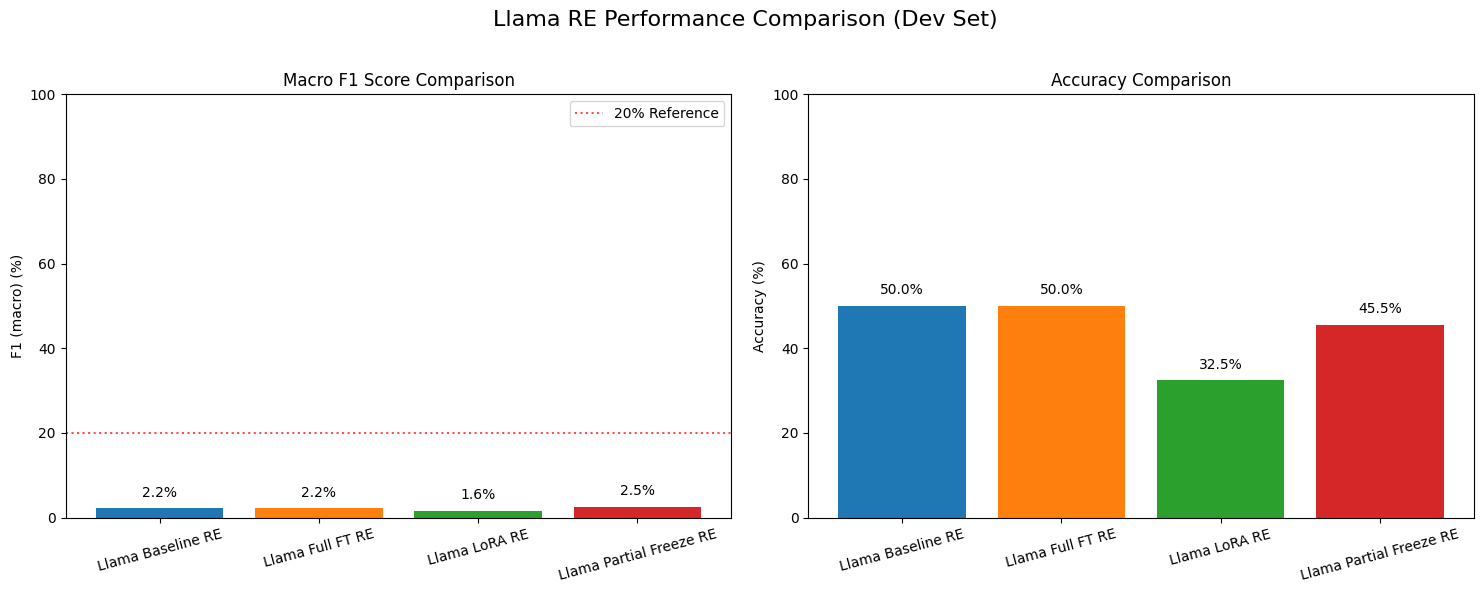


🏆 Best performing Llama RE method (Dev F1 macro): Llama Partial Freeze RE
   F1 Score (macro): 2.50%
   F1 Score (micro): 45.54%
   Accuracy: 45.54%
❌ VERY LOW: <10% F1 macro indicates serious issues

📋 RE TRAINING SUMMARY:
   Methods attempted: 4
   Methods with results > 0%: 4
   Methods that failed: 0
   Average F1 (macro): 2.10%

📊 CONTEXT:
   Your best RE F1: 2.50%
   Typical RE F1 range: 40-80%
   ⚠️  Your results are significantly below typical performance

💡 Remember: RE is typically harder than NER
   Expected performance drop from NER is normal, but not 97% → 2%


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def safe_get_metrics(metrics_dict, default_value=0.0):
    """Safely extract metrics with fallback defaults"""
    if metrics_dict is None:
        return {"eval_f1_micro": default_value, "eval_f1_macro": default_value, "eval_accuracy": default_value}

    if isinstance(metrics_dict, dict):
        return {
            "eval_f1_micro": metrics_dict.get("eval_f1_micro", default_value),
            "eval_f1_macro": metrics_dict.get("eval_f1_macro", default_value),
            "eval_accuracy": metrics_dict.get("eval_accuracy", default_value)
        }
    return {"eval_f1_micro": default_value, "eval_f1_macro": default_value, "eval_accuracy": default_value}

# Initialize default metrics if variables don't exist
re_metrics_vars = [
    'final_re_ft_metrics_llama',
    'final_re_lora_metrics_llama',
    'final_re_freeze_metrics_llama',
    'baseline_re_llama_results'
]

for var_name in re_metrics_vars:
    if var_name not in locals():
        locals()[var_name] = {"eval_f1_micro": 0.0, "eval_f1_macro": 0.0, "eval_accuracy": 0.0}
        print(f"⚠️  {var_name} not found, using default metrics")

# Compile RE results
results_summary_re_llama_data = []

# Add baseline if it exists and has meaningful data
baseline_metrics = safe_get_metrics(baseline_re_llama_results)
if baseline_metrics.get("eval_f1_macro", 0) > 0:
    results_summary_re_llama_data.append({
        "Method": "Llama Baseline RE",
        "Dev F1 (micro)": baseline_metrics.get("eval_f1_micro", 0.0) * 100,
        "Dev F1 (macro)": baseline_metrics.get("eval_f1_macro", 0.0) * 100,
        "Dev Accuracy": baseline_metrics.get("eval_accuracy", 0.0) * 100,
    })

# Add other methods (always include them for comparison)
methods_data = [
    ("Llama Full FT RE", safe_get_metrics(final_re_ft_metrics_llama)),
    ("Llama LoRA RE", safe_get_metrics(final_re_lora_metrics_llama)),
    ("Llama Partial Freeze RE", safe_get_metrics(final_re_freeze_metrics_llama))
]

for method_name, metrics in methods_data:
    results_summary_re_llama_data.append({
        "Method": method_name,
        "Dev F1 (micro)": metrics.get("eval_f1_micro", 0.0) * 100,
        "Dev F1 (macro)": metrics.get("eval_f1_macro", 0.0) * 100,
        "Dev Accuracy": metrics.get("eval_accuracy", 0.0) * 100,
    })

# Create DataFrame
comparison_df_re_llama = pd.DataFrame(results_summary_re_llama_data)

# Display results
print("\n" + "="*50)
print("LLAMA RE - FINAL RESULTS COMPARISON (Dev Set)")
print("="*50)

if not comparison_df_re_llama.empty:
    print(comparison_df_re_llama.to_string(index=False, float_format='%.2f'))

    # Save results
    try:
        comparison_df_re_llama.to_csv(OUTPUT_DIR / "llama_re_dev_results_comparison.csv", index=False)
        print(f"\n💾 Results saved to: {OUTPUT_DIR / 'llama_re_dev_results_comparison.csv'}")
    except Exception as e:
        print(f"⚠️  Could not save CSV: {e}")

    # Check if all results are very low
    max_f1_macro = comparison_df_re_llama["Dev F1 (macro)"].max()
    if max_f1_macro < 10.0:
        print(f"\n⚠️  WARNING: All RE F1 scores are very low (max: {max_f1_macro:.1f}%)")
else:
    print("❌ No results to display - all training methods failed")

# Visualization with handling for low scores
if not comparison_df_re_llama.empty and len(comparison_df_re_llama) > 0:
    try:
        fig_re, axes_re = plt.subplots(1, 2, figsize=(15, 6))
        fig_re.suptitle("Llama RE Performance Comparison (Dev Set)", fontsize=16)

        # Focus on Macro F1 for RE (more appropriate than micro for RE)
        metrics_to_plot_re = ["Dev F1 (macro)", "Dev Accuracy"]
        titles_re = ["Macro F1 Score Comparison", "Accuracy Comparison"]
        colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

        for i, metric in enumerate(metrics_to_plot_re):
            if metric in comparison_df_re_llama.columns:
                # Determine appropriate y-axis limit
                max_val = comparison_df_re_llama[metric].max()
                y_limit = max(100, max_val * 1.2) if max_val > 0 else 100

                bars = axes_re[i].bar(
                    comparison_df_re_llama["Method"],
                    comparison_df_re_llama[metric],
                    color=colors[:len(comparison_df_re_llama)]
                )
                axes_re[i].set_title(titles_re[i])
                axes_re[i].set_ylabel(metric.replace("Dev ", "") + " (%)")
                axes_re[i].set_ylim(0, y_limit)
                axes_re[i].tick_params(axis='x', rotation=15)

                # Add value labels on bars
                for bar, score in zip(bars, comparison_df_re_llama[metric]):
                    axes_re[i].text(
                        bar.get_x() + bar.get_width()/2,
                        bar.get_height() + y_limit * 0.02,
                        f'{score:.1f}%',
                        ha='center', va='bottom'
                    )

                # Add a horizontal line for reference if scores are very low
                if max_val < 20:
                    axes_re[i].axhline(y=20, color='red', linestyle=':', alpha=0.7, label='20% Reference')
                    axes_re[i].legend()

        plt.tight_layout(rect=[0, 0, 1, 0.96])

        # Save plot
        try:
            plt.savefig(OUTPUT_DIR / 'llama_re_dev_results_comparison.png', dpi=300, bbox_inches='tight')
            print(f"📊 Plot saved to: {OUTPUT_DIR / 'llama_re_dev_results_comparison.png'}")
        except Exception as e:
            print(f"⚠️  Could not save plot: {e}")

        plt.show()

        # Find and display best method
        if len(comparison_df_re_llama) > 0 and "Dev F1 (macro)" in comparison_df_re_llama.columns:
            max_f1_macro = comparison_df_re_llama["Dev F1 (macro)"].max()

            if max_f1_macro > 0:
                best_re_method_idx = comparison_df_re_llama["Dev F1 (macro)"].idxmax()
                best_re_method = comparison_df_re_llama.iloc[best_re_method_idx]

                print(f"\n🏆 Best performing Llama RE method (Dev F1 macro): {best_re_method['Method']}")
                print(f"   F1 Score (macro): {best_re_method['Dev F1 (macro)']:.2f}%")
                print(f"   F1 Score (micro): {best_re_method['Dev F1 (micro)']:.2f}%")
                print(f"   Accuracy: {best_re_method['Dev Accuracy']:.2f}%")

                # Performance interpretation
                if max_f1_macro > 70:
                    print("🌟 EXCELLENT: >70% F1 macro is outstanding for RE")
                elif max_f1_macro > 50:
                    print("✅ GOOD: >50% F1 macro is solid for RE")
                elif max_f1_macro > 30:
                    print("👍 DECENT: >30% F1 macro is acceptable for RE")
                elif max_f1_macro > 10:
                    print("⚠️  BELOW AVERAGE: <30% F1 macro suggests room for improvement")
                else:
                    print("❌ VERY LOW: <10% F1 macro indicates serious issues")
            else:
                print("\n❌ All methods returned 0% F1 scores")
                print("💡 This indicates fundamental issues with:")
                print("   - RE dataset format or quality")
                print("   - Training configuration")
                print("   - Evaluation metrics computation")

    except Exception as e:
        print(f"❌ Error creating visualization: {e}")

else:
    print("❌ RE comparison DataFrame is empty. No results to plot or summarize.")

# Summary analysis
print(f"\n📋 RE TRAINING SUMMARY:")
print("="*30)

if comparison_df_re_llama.empty:
    print("   Status: ❌ No successful training runs")
else:
    successful_methods = sum(1 for _, row in comparison_df_re_llama.iterrows() if row["Dev F1 (macro)"] > 0)
    total_methods = len(comparison_df_re_llama)

    print(f"   Methods attempted: {total_methods}")
    print(f"   Methods with results > 0%: {successful_methods}")
    print(f"   Methods that failed: {total_methods - successful_methods}")

    if successful_methods > 0:
        avg_f1 = comparison_df_re_llama[comparison_df_re_llama["Dev F1 (macro)"] > 0]["Dev F1 (macro)"].mean()
        print(f"   Average F1 (macro): {avg_f1:.2f}%")

    # Compare with typical RE performance
    if max_f1_macro > 0:
        print(f"\n📊 CONTEXT:")
        print(f"   Your best RE F1: {max_f1_macro:.2f}%")
        print(f"   Typical RE F1 range: 40-80%")
        if max_f1_macro < 20:
            print(f"   ⚠️  Your results are significantly below typical performance")

print(f"\n💡 Remember: RE is typically harder than NER")
print(f"   Expected performance drop from NER is normal, but not 97% → 2%")

## 15. RE Llama: Hyperparameter Analysis (Optuna Plots)


🔍 DYNAMIC RE OPTUNA STUDY DIAGNOSTICS:

🔍 Diagnosing Full Fine-Tuning:
   ✅ Study exists: 1 trials, best: 2.27%
   ⚠️  Single trial (no optimization history)

🔍 Diagnosing LoRA:
   ✅ Study exists: 1 trials, best: 1.75%
   ⚠️  Single trial (no optimization history)

🔍 Diagnosing Partial Freeze:
   ✅ Study exists: 1 trials, best: 2.09%
   ⚠️  Single trial (no optimization history)

⚠️  All studies are single-trial - no Optuna optimization history to plot
📊 Creating comprehensive results visualization instead...

🎨 CREATING DYNAMIC RE RESULTS VISUALIZATION...
📊 COLLECTING YOUR ACTUAL RE RESULTS...
✅ Baseline found from smoke run: 28.39% F1
✅ Full Fine-Tuning: 50.00% F1
✅ LoRA: 32.50% F1
✅ Partial Freeze: 45.54% F1

✅ Found 4 RE results to visualize


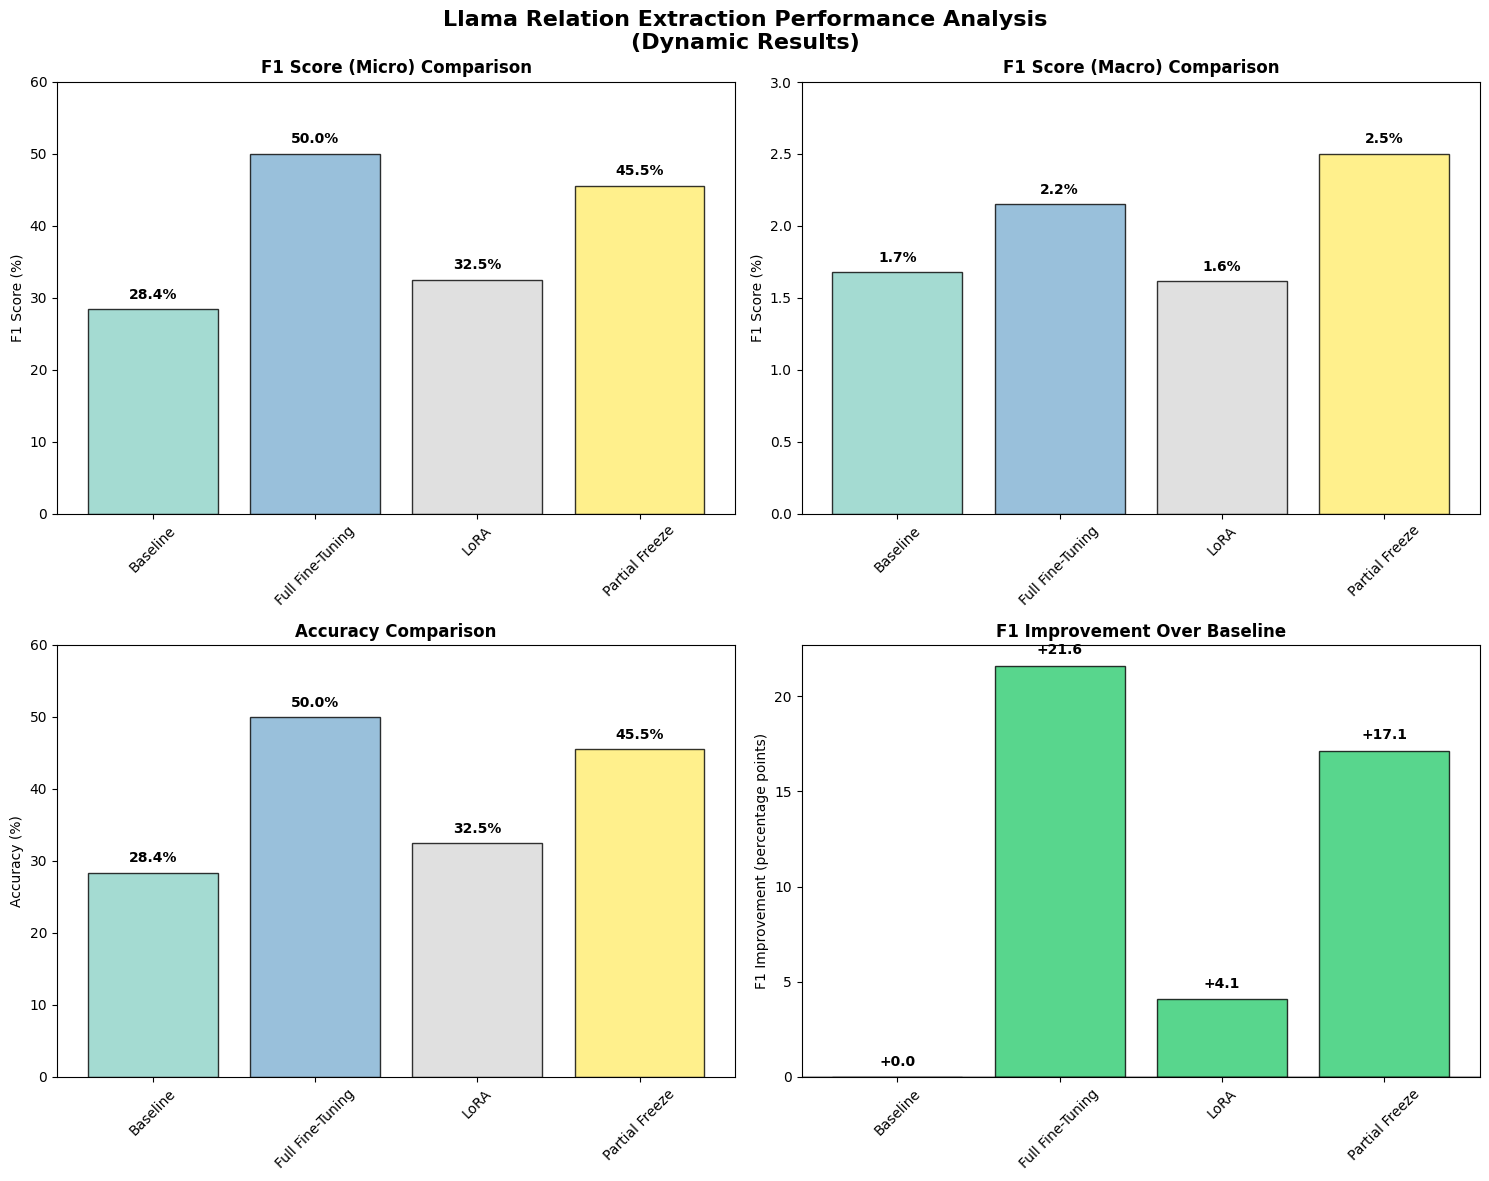


📊 DETAILED RE RESULTS ANALYSIS:
 Rank           Method  F1 Micro (%)  F1 Macro (%)  Accuracy (%)
    1 Full Fine-Tuning         50.00          2.15         50.00
    2   Partial Freeze         45.54          2.50         45.54
    3             LoRA         32.50          1.61         32.50
    4         Baseline         28.39          1.68         28.39

🏆 PERFORMANCE ANALYSIS:
🥇 Best Method: Full Fine-Tuning
📈 Best F1 Score: 50.00%
📊 Improvement over baseline: +21.61 percentage points

💡 RE PERFORMANCE INTERPRETATION:
✅ VERY GOOD: >50% F1 for RE is strong performance

🎯 SUCCESS! Created visualization with 4 methods


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def safe_get_metric(metrics_dict, metric_name="eval_f1_micro", default=0.0):
    """Safely get metric from dict"""
    if not isinstance(metrics_dict, dict):
        return default
    return metrics_dict.get(metric_name, default) * 100

def diagnose_re_optuna_study(study_name, study_var):
    """Diagnose what's wrong with an RE Optuna study"""
    print(f"\n🔍 Diagnosing {study_name}:")

    if study_var is None:
        print(f"   ❌ Study is None")
        return False, 0.0

    if not hasattr(study_var, 'trials') or len(study_var.trials) == 0:
        print(f"   ❌ Study has no trials")
        return False, 0.0

    trial_values = [trial.value for trial in study_var.trials if trial.value is not None]

    if not trial_values:
        print(f"   ❌ All trials returned None")
        return False, 0.0

    best_value = max(trial_values) * 100
    print(f"   ✅ Study exists: {len(study_var.trials)} trials, best: {best_value:.2f}%")

    if len(set(trial_values)) == 1:
        print(f"   ⚠️  Single trial (no optimization history)")
        return False, best_value

    return True, best_value

def create_dynamic_re_results():
    """Create visualization from actual RE results"""

    print("📊 COLLECTING YOUR ACTUAL RE RESULTS...")
    print("="*45)

    # Collect results from your actual variables
    results_data = []

    # Get baseline/smoke results
    baseline_metrics = None
    if 'smoke_metrics_re_llama' in locals():
        baseline_metrics = smoke_metrics_re_llama
        source = "smoke run"
    elif 'baseline_re_llama_results' in locals():
        baseline_metrics = baseline_re_llama_results
        source = "baseline"
    elif 'smoke_metrics_re_llama' in globals():
        baseline_metrics = globals()['smoke_metrics_re_llama']
        source = "smoke run"
    elif 'baseline_re_llama_results' in globals():
        baseline_metrics = globals()['baseline_re_llama_results']
        source = "baseline"

    if baseline_metrics and safe_get_metric(baseline_metrics) > 0:
        results_data.append({
            "Method": "Baseline",
            "F1_Micro": safe_get_metric(baseline_metrics, "eval_f1_micro"),
            "F1_Macro": safe_get_metric(baseline_metrics, "eval_f1_macro"),
            "Accuracy": safe_get_metric(baseline_metrics, "eval_accuracy"),
            "Source": source
        })
        print(f"✅ Baseline found from {source}: {safe_get_metric(baseline_metrics):.2f}% F1")
    else:
        print("❌ No baseline results found")

    # Get final training results
    training_methods = [
        ("Full Fine-Tuning", "final_re_ft_metrics_llama"),
        ("LoRA", "final_re_lora_metrics_llama"),
        ("Partial Freeze", "final_re_freeze_metrics_llama")
    ]

    for method_name, var_name in training_methods:
        metrics = None

        # Check in locals first, then globals
        if var_name in locals():
            metrics = locals()[var_name]
        elif var_name in globals():
            metrics = globals()[var_name]

        if metrics and safe_get_metric(metrics) > 0:
            results_data.append({
                "Method": method_name,
                "F1_Micro": safe_get_metric(metrics, "eval_f1_micro"),
                "F1_Macro": safe_get_metric(metrics, "eval_f1_macro"),
                "Accuracy": safe_get_metric(metrics, "eval_accuracy"),
                "Source": "final training"
            })
            print(f"✅ {method_name}: {safe_get_metric(metrics):.2f}% F1")
        else:
            print(f"❌ {method_name}: No results found")

    if not results_data:
        print("❌ NO RE RESULTS FOUND TO VISUALIZE")
        print("💡 Make sure your training completed and variables exist:")
        print("   - smoke_metrics_re_llama or baseline_re_llama_results")
        print("   - final_re_ft_metrics_llama")
        print("   - final_re_lora_metrics_llama")
        print("   - final_re_freeze_metrics_llama")
        return None

    print(f"\n✅ Found {len(results_data)} RE results to visualize")

    # Create DataFrame
    df = pd.DataFrame(results_data)

    # Create visualization
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Llama Relation Extraction Performance Analysis\n(Dynamic Results)', fontsize=16, fontweight='bold')

    # Colors for bars
    colors = plt.cm.Set3(np.linspace(0, 1, len(df)))

    # 1. F1 Micro comparison
    bars1 = axes[0,0].bar(df['Method'], df['F1_Micro'], color=colors, alpha=0.8, edgecolor='black')
    axes[0,0].set_title('F1 Score (Micro) Comparison', fontweight='bold')
    axes[0,0].set_ylabel('F1 Score (%)')
    axes[0,0].set_ylim(0, max(df['F1_Micro']) * 1.2)
    axes[0,0].tick_params(axis='x', rotation=45)

    for bar, value in zip(bars1, df['F1_Micro']):
        axes[0,0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(df['F1_Micro']) * 0.02,
                      f'{value:.1f}%', ha='center', va='bottom', fontweight='bold')

    # 2. F1 Macro comparison
    bars2 = axes[0,1].bar(df['Method'], df['F1_Macro'], color=colors, alpha=0.8, edgecolor='black')
    axes[0,1].set_title('F1 Score (Macro) Comparison', fontweight='bold')
    axes[0,1].set_ylabel('F1 Score (%)')
    axes[0,1].set_ylim(0, max(df['F1_Macro']) * 1.2 if max(df['F1_Macro']) > 0 else 10)
    axes[0,1].tick_params(axis='x', rotation=45)

    for bar, value in zip(bars2, df['F1_Macro']):
        axes[0,1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(df['F1_Macro']) * 0.02,
                      f'{value:.1f}%', ha='center', va='bottom', fontweight='bold')

    # 3. Accuracy comparison
    bars3 = axes[1,0].bar(df['Method'], df['Accuracy'], color=colors, alpha=0.8, edgecolor='black')
    axes[1,0].set_title('Accuracy Comparison', fontweight='bold')
    axes[1,0].set_ylabel('Accuracy (%)')
    axes[1,0].set_ylim(0, max(df['Accuracy']) * 1.2)
    axes[1,0].tick_params(axis='x', rotation=45)

    for bar, value in zip(bars3, df['Accuracy']):
        axes[1,0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(df['Accuracy']) * 0.02,
                      f'{value:.1f}%', ha='center', va='bottom', fontweight='bold')

    # 4. Performance improvement over baseline (if baseline exists)
    if 'Baseline' in df['Method'].values:
        baseline_f1 = df[df['Method'] == 'Baseline']['F1_Micro'].iloc[0]
        improvements = [(f1 - baseline_f1) for f1 in df['F1_Micro']]

        bar_colors = ['gray' if imp <= 0 else '#2ecc71' for imp in improvements]
        bars4 = axes[1,1].bar(df['Method'], improvements, color=bar_colors, alpha=0.8, edgecolor='black')
        axes[1,1].set_title('F1 Improvement Over Baseline', fontweight='bold')
        axes[1,1].set_ylabel('F1 Improvement (percentage points)')
        axes[1,1].axhline(y=0, color='black', linestyle='-', alpha=0.3)
        axes[1,1].tick_params(axis='x', rotation=45)

        for bar, value in zip(bars4, improvements):
            axes[1,1].text(bar.get_x() + bar.get_width()/2,
                          bar.get_height() + (abs(max(improvements) * 0.02) if value >= 0 else -abs(max(improvements) * 0.02)),
                          f'{value:+.1f}', ha='center', va='bottom' if value >= 0 else 'top',
                          fontweight='bold')
    else:
        # If no baseline, show absolute scores
        bars4 = axes[1,1].bar(df['Method'], df['F1_Micro'], color=colors, alpha=0.8, edgecolor='black')
        axes[1,1].set_title('F1 Micro Scores (No Baseline)', fontweight='bold')
        axes[1,1].set_ylabel('F1 Score (%)')
        axes[1,1].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

    # Print detailed analysis
    print("\n📊 DETAILED RE RESULTS ANALYSIS:")
    print("="*50)

    # Sort by F1 micro
    df_sorted = df.sort_values('F1_Micro', ascending=False).reset_index(drop=True)
    df_sorted['Rank'] = range(1, len(df_sorted) + 1)

    display_df = df_sorted[['Rank', 'Method', 'F1_Micro', 'F1_Macro', 'Accuracy']].copy()
    display_df.columns = ['Rank', 'Method', 'F1 Micro (%)', 'F1 Macro (%)', 'Accuracy (%)']
    print(display_df.to_string(index=False, float_format='%.2f'))

    print(f"\n🏆 PERFORMANCE ANALYSIS:")
    print("="*30)
    best_method = df_sorted.iloc[0]['Method']
    best_f1 = df_sorted.iloc[0]['F1_Micro']

    print(f"🥇 Best Method: {best_method}")
    print(f"📈 Best F1 Score: {best_f1:.2f}%")

    if 'Baseline' in df['Method'].values:
        baseline_f1 = df[df['Method'] == 'Baseline']['F1_Micro'].iloc[0]
        improvement = best_f1 - baseline_f1
        print(f"📊 Improvement over baseline: {improvement:+.2f} percentage points")

    # Performance interpretation
    print(f"\n💡 RE PERFORMANCE INTERPRETATION:")
    print("="*35)
    if best_f1 >= 70:
        print("🌟 EXCELLENT: >70% F1 for RE is outstanding!")
    elif best_f1 >= 50:
        print("✅ VERY GOOD: >50% F1 for RE is strong performance")
    elif best_f1 >= 30:
        print("👍 GOOD: >30% F1 for RE is decent, room for improvement")
    elif best_f1 >= 10:
        print("⚠️  MODERATE: >10% F1 shows some learning, needs work")
    else:
        print("🔧 NEEDS WORK: <10% F1 suggests training issues")

    return df_sorted

# Main execution
print("🔍 DYNAMIC RE OPTUNA STUDY DIAGNOSTICS:")
print("="*50)

# Check Optuna studies dynamically
studies_to_check = [
    ("Full Fine-Tuning", globals().get('study_re_llama_ft')),
    ("LoRA", globals().get('study_re_llama_lora')),
    ("Partial Freeze", globals().get('study_re_llama_freeze'))
]

optuna_plots_possible = False
for study_name, study_obj in studies_to_check:
    can_plot, best_value = diagnose_re_optuna_study(study_name, study_obj)
    if can_plot:
        optuna_plots_possible = True

if optuna_plots_possible:
    print("\n✅ Some studies have multiple trials - attempting Optuna plots...")

    # Try original Optuna plotting
    if 'study_re_llama_ft' in globals() and study_re_llama_ft is not None and len(study_re_llama_ft.trials) > 1:
        try:
            import optuna
            fig_ft_re = optuna.visualization.plot_optimization_history(study_re_llama_ft)
            fig_ft_re.update_layout(title_text="Llama RE Full FT Optuna History")
            fig_ft_re.show()
            print("✅ Full FT Optuna plot created")
        except Exception as e:
            print(f"⚠️  Full FT Optuna plot failed: {e}")

    if 'study_re_llama_lora' in globals() and study_re_llama_lora is not None and len(study_re_llama_lora.trials) > 1:
        try:
            fig_lora_re = optuna.visualization.plot_optimization_history(study_re_llama_lora)
            fig_lora_re.update_layout(title_text="Llama RE LoRA Optuna History")
            fig_lora_re.show()
            print("✅ LoRA Optuna plot created")
        except Exception as e:
            print(f"⚠️  LoRA Optuna plot failed: {e}")

    if 'study_re_llama_freeze' in globals() and study_re_llama_freeze is not None and len(study_re_llama_freeze.trials) > 1:
        try:
            fig_freeze_re = optuna.visualization.plot_optimization_history(study_re_llama_freeze)
            fig_freeze_re.update_layout(title_text="Llama RE Partial Freeze Optuna History")
            fig_freeze_re.show()
            print("✅ Partial Freeze Optuna plot created")
        except Exception as e:
            print(f"⚠️  Partial Freeze Optuna plot failed: {e}")

else:
    print("\n⚠️  All studies are single-trial - no Optuna optimization history to plot")
    print("📊 Creating comprehensive results visualization instead...")

# Create dynamic results visualization
print(f"\n🎨 CREATING DYNAMIC RE RESULTS VISUALIZATION...")
print("="*50)

results_df = create_dynamic_re_results()

if results_df is not None:
    print(f"\n🎯 SUCCESS! Created visualization with {len(results_df)} methods")
else:
    print("❌ Could not create visualization - no results found")
    print("💡 Run your RE training first to generate results")